In [1]:
import keras
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.layers import Dense, Activation, Dropout, Flatten ,Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras import Sequential 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.models import Model
from keras.callbacks import History,EarlyStopping,Callback,CallbackList,ReduceLROnPlateau



import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator ,load_img

from sklearn.model_selection import train_test_split


import random
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2                                
import pandas as pd                    
                    
#時間
import datetime



Using TensorFlow backend.


In [28]:
import gc

參考資料
https://www.kaggle.com/jutrera/training-a-densenet-for-the-stanford-car-dataset

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator



In [2]:
'''
setting gpu usage
'''
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6144)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
from keras.applications.densenet import DenseNet121

In [66]:
'''Config'''
train_image_path= './DataSet/C1-P1_Train'
train_label_path = './Doc/train.csv'
valid_image_path = './DataSet/C1-P1_Dev'
valiid_label_path = './Doc/dev.csv'
test_image_path = './DataSet/C1-P1_Test'
test_upload_file = './Doc/test_example.csv'


# Model
batch_size = 16
epochs = 500
img_szie = (224,224)

In [31]:
''' 
load image with cv2
'''
Image_size = (224,224)

def loadImageDataSet(file_path):
    temp = 2 #紀錄照片屬於哪個資料夾，以賦予照片唯一ID
    file_names = os.listdir(file_path)
    x_imgs = []
    for image in file_names:
        #category='n'+str(temp)
        img = cv2.imread(file_path+'/'+image)
        img_resize = cv2.resize(img,Image_size,interpolation=cv2.INTER_CUBIC)
        x_imgs.append(img_resize)
        image = image.split('.')[0]
        print(img)
        del img 
        gc.collect()
    
    return x_imgs

def changeRGBchannel(images_arr):
    for i in range(0,len(images_arr)):
        images_arr[i] = images_arr[i][:,:,::-1]
    return images_arr


y_train_origin = loadImageDataSet(test_image_path)

[[[110 112 106]
  [110 112 106]
  [111 113 107]
  ...
  [122 118 117]
  [121 117 116]
  [121 117 116]]

 [[111 113 107]
  [111 113 107]
  [112 114 108]
  ...
  [122 118 117]
  [121 117 116]
  [121 117 116]]

 [[112 114 108]
  [112 114 108]
  [113 115 109]
  ...
  [122 118 117]
  [121 117 116]
  [121 117 116]]

 ...

 [[ 98  95  90]
  [ 98  95  90]
  [ 98  95  90]
  ...
  [125 113 149]
  [124 112 148]
  [123 111 147]]

 [[100  97  92]
  [100  97  92]
  [100  97  92]
  ...
  [127 114 152]
  [127 114 152]
  [126 113 151]]

 [[101  98  93]
  [101  98  93]
  [101  98  93]
  ...
  [129 116 154]
  [129 116 154]
  [129 116 154]]]
[[[154 160 171]
  [143 149 160]
  [140 146 157]
  ...
  [192 211 219]
  [192 211 219]
  [192 211 219]]

 [[152 158 169]
  [145 151 162]
  [144 150 161]
  ...
  [192 211 219]
  [192 211 219]
  [192 211 219]]

 [[158 164 175]
  [153 159 170]
  [155 161 172]
  ...
  [192 211 219]
  [192 211 219]
  [192 211 219]]

 ...

 [[ 12  23  20]
  [  5  16  13]
  [  5  18  16]
  ..

[[[ 23  22  24]
  [ 21  20  22]
  [ 19  18  20]
  ...
  [ 28  33  36]
  [ 28  33  36]
  [ 28  33  36]]

 [[ 22  21  23]
  [ 21  20  22]
  [ 19  18  20]
  ...
  [ 28  33  36]
  [ 28  33  36]
  [ 28  33  36]]

 [[ 22  21  23]
  [ 20  19  21]
  [ 20  19  21]
  ...
  [ 28  33  36]
  [ 28  33  36]
  [ 28  33  36]]

 ...

 [[159 167 166]
  [162 170 169]
  [164 172 171]
  ...
  [119 141 176]
  [120 142 177]
  [122 144 179]]

 [[160 168 167]
  [160 168 167]
  [160 168 167]
  ...
  [118 140 175]
  [121 143 178]
  [124 146 181]]

 [[162 170 169]
  [158 166 165]
  [156 164 163]
  ...
  [117 139 174]
  [122 144 179]
  [126 148 183]]]
[[[205 128  35]
  [210 133  37]
  [213 131  36]
  ...
  [116 124 123]
  [113 121 120]
  [112 120 119]]

 [[203 125  32]
  [207 130  34]
  [212 130  35]
  ...
  [117 125 124]
  [117 125 124]
  [117 125 124]]

 [[211 131  36]
  [214 134  39]
  [217 135  40]
  ...
  [118 126 125]
  [119 127 126]
  [120 128 127]]

 ...

 [[196 135  37]
  [198 137  39]
  [198 137  41]
  ..

[[[ 21  39  56]
  [ 26  44  61]
  [ 31  46  62]
  ...
  [ 26  23  19]
  [ 26  23  19]
  [ 23  20  16]]

 [[ 19  35  52]
  [ 24  40  56]
  [ 27  42  58]
  ...
  [ 26  23  19]
  [ 25  22  18]
  [ 22  19  15]]

 [[ 15  30  46]
  [ 20  36  49]
  [ 25  38  52]
  ...
  [ 26  23  19]
  [ 25  22  18]
  [ 21  18  14]]

 ...

 [[204 215 219]
  [204 215 219]
  [204 215 219]
  ...
  [158 164 205]
  [159 165 208]
  [160 166 209]]

 [[204 215 219]
  [204 215 219]
  [203 214 218]
  ...
  [158 164 205]
  [159 165 206]
  [160 166 207]]

 [[204 215 219]
  [204 215 219]
  [203 214 218]
  ...
  [158 164 205]
  [159 165 206]
  [160 166 207]]]
[[[126 200 242]
  [124 198 240]
  [123 197 239]
  ...
  [143 158 161]
  [141 156 159]
  [140 155 158]]

 [[125 197 239]
  [124 196 238]
  [123 195 237]
  ...
  [143 158 161]
  [142 157 160]
  [140 155 158]]

 [[124 192 235]
  [123 191 234]
  [122 190 233]
  ...
  [143 158 161]
  [142 157 160]
  [141 156 159]]

 ...

 [[194 103  22]
  [191 100  19]
  [191 102  21]
  ..

[[[154 162 152]
  [154 162 152]
  [154 162 152]
  ...
  [157 160 145]
  [157 160 145]
  [157 160 145]]

 [[154 162 152]
  [154 162 152]
  [154 162 152]
  ...
  [157 160 145]
  [157 160 145]
  [158 161 146]]

 [[154 162 152]
  [154 162 152]
  [154 162 152]
  ...
  [158 161 146]
  [158 161 146]
  [158 161 146]]

 ...

 [[142 146 134]
  [142 146 134]
  [142 146 134]
  ...
  [150 146 181]
  [149 145 180]
  [149 145 180]]

 [[142 146 134]
  [142 146 134]
  [142 146 134]
  ...
  [149 145 180]
  [149 145 180]
  [148 144 179]]

 [[142 146 134]
  [142 146 134]
  [142 146 134]
  ...
  [149 145 180]
  [148 144 179]
  [148 144 179]]]
[[[137 141 142]
  [139 143 144]
  [143 147 148]
  ...
  [ 37  48  70]
  [ 37  48  70]
  [ 37  48  70]]

 [[137 141 142]
  [139 143 144]
  [143 147 148]
  ...
  [ 37  48  70]
  [ 37  48  70]
  [ 37  48  70]]

 [[137 141 142]
  [140 144 145]
  [143 147 148]
  ...
  [ 37  48  70]
  [ 37  48  70]
  [ 37  48  70]]

 ...

 [[ 92 105 113]
  [ 91 104 112]
  [ 91 104 112]
  ..

[[[  9  10  14]
  [  9  10  14]
  [  9  10  14]
  ...
  [153 154 152]
  [152 153 151]
  [151 152 150]]

 [[  9  10  14]
  [  9  10  14]
  [  9  10  14]
  ...
  [154 155 153]
  [153 154 152]
  [152 153 151]]

 [[  9  10  14]
  [  9  10  14]
  [  9  10  14]
  ...
  [154 155 153]
  [153 154 152]
  [153 154 152]]

 ...

 [[205 162 195]
  [207 163 199]
  [208 164 203]
  ...
  [131 128 174]
  [141 138 184]
  [148 145 191]]

 [[192 142 190]
  [188 139 189]
  [185 136 190]
  ...
  [146 140 187]
  [154 151 197]
  [162 159 205]]

 [[166 113 170]
  [161 110 168]
  [156 105 165]
  ...
  [159 153 200]
  [164 161 207]
  [169 166 212]]]
[[[ 59  45  22]
  [ 59  45  22]
  [ 58  44  22]
  ...
  [108  99  85]
  [108  99  85]
  [108  99  85]]

 [[ 61  47  25]
  [ 61  47  25]
  [ 60  46  24]
  ...
  [108  99  85]
  [108  99  85]
  [108  99  85]]

 [[ 62  47  28]
  [ 62  47  28]
  [ 62  47  28]
  ...
  [108  99  85]
  [108  99  85]
  [108  99  85]]

 ...

 [[ 72 122 112]
  [ 67 117 107]
  [ 67 114 105]
  ..

[[[ 63  49  43]
  [ 62  48  42]
  [ 61  47  41]
  ...
  [ 22  18  17]
  [ 22  18  17]
  [ 22  18  17]]

 [[ 63  49  43]
  [ 62  48  42]
  [ 62  48  42]
  ...
  [ 22  18  17]
  [ 22  18  17]
  [ 22  18  17]]

 [[ 64  50  44]
  [ 63  49  43]
  [ 62  48  42]
  ...
  [ 21  17  16]
  [ 21  17  16]
  [ 21  17  16]]

 ...

 [[ 68  66 125]
  [ 68  66 125]
  [ 67  65 124]
  ...
  [197 160 162]
  [197 160 162]
  [196 159 161]]

 [[ 69  67 126]
  [ 68  66 125]
  [ 68  66 125]
  ...
  [194 157 159]
  [194 157 159]
  [195 158 160]]

 [[ 69  67 126]
  [ 69  67 126]
  [ 68  66 125]
  ...
  [192 155 157]
  [192 155 157]
  [194 157 159]]]
[[[121 108  86]
  [120 109  89]
  [115 106  92]
  ...
  [ 60  65  56]
  [ 63  68  59]
  [ 64  69  60]]

 [[123 110  88]
  [122 111  91]
  [116 107  93]
  ...
  [ 57  62  53]
  [ 62  67  58]
  [ 64  69  60]]

 [[126 112  93]
  [124 112  94]
  [117 108  94]
  ...
  [ 56  61  52]
  [ 60  65  56]
  [ 63  68  59]]

 ...

 [[136 146 140]
  [140 150 144]
  [144 154 148]
  ..

[[[ 82 113 116]
  [ 66  97 100]
  [ 46  76  77]
  ...
  [ 52  52  46]
  [ 51  51  45]
  [ 48  48  42]]

 [[ 75 106 109]
  [ 56  87  90]
  [ 35  65  66]
  ...
  [ 52  52  46]
  [ 52  52  46]
  [ 50  50  44]]

 [[ 63  94  97]
  [ 42  73  76]
  [ 22  51  55]
  ...
  [ 53  53  47]
  [ 53  53  47]
  [ 52  52  46]]

 ...

 [[ 53  46  31]
  [ 50  43  28]
  [ 48  41  26]
  ...
  [ 76  69 102]
  [ 74  69 101]
  [ 73  68 100]]

 [[ 50  43  28]
  [ 50  43  28]
  [ 50  43  28]
  ...
  [ 78  71 104]
  [ 76  71 103]
  [ 74  69 101]]

 [[ 48  41  26]
  [ 49  42  27]
  [ 52  45  30]
  ...
  [ 80  73 106]
  [ 77  72 104]
  [ 75  70 102]]]
[[[ 32  32 116]
  [ 30  31 112]
  [ 32  32 108]
  ...
  [132 133 137]
  [133 134 138]
  [134 135 139]]

 [[ 33  34 115]
  [ 34  35 115]
  [ 37  37 113]
  ...
  [132 133 137]
  [133 134 138]
  [134 135 139]]

 [[ 32  33 113]
  [ 35  38 113]
  [ 37  39 110]
  ...
  [132 133 137]
  [133 134 138]
  [133 134 138]]

 ...

 [[ 82  91  88]
  [ 84  93  90]
  [ 87  96  93]
  ..

[[[ 47  41  30]
  [ 47  41  30]
  [ 49  43  32]
  ...
  [ 27  34  21]
  [ 19  26  13]
  [ 11  18   5]]

 [[ 48  42  31]
  [ 49  43  32]
  [ 50  44  33]
  ...
  [ 16  23  10]
  [  9  15   4]
  [  3  10   0]]

 [[ 50  44  33]
  [ 50  44  33]
  [ 51  45  34]
  ...
  [  4  10   0]
  [  0   5   0]
  [  0   4   0]]

 ...

 [[106  93  77]
  [106  93  77]
  [106  93  77]
  ...
  [146 149 177]
  [148 151 179]
  [146 149 177]]

 [[106  93  77]
  [106  93  77]
  [106  93  77]
  ...
  [146 149 177]
  [148 151 179]
  [146 149 177]]

 [[106  93  77]
  [106  93  77]
  [106  93  77]
  ...
  [146 149 177]
  [147 150 178]
  [146 149 177]]]
[[[185 182 177]
  [185 182 177]
  [185 182 177]
  ...
  [145 157 159]
  [145 157 159]
  [145 157 159]]

 [[185 182 177]
  [185 182 177]
  [185 182 177]
  ...
  [145 157 159]
  [145 157 159]
  [145 157 159]]

 [[184 181 176]
  [184 181 176]
  [184 181 176]
  ...
  [145 157 159]
  [145 157 159]
  [145 157 159]]

 ...

 [[144 156 160]
  [144 156 160]
  [145 157 161]
  ..

[[[132 145 131]
  [135 148 134]
  [138 151 137]
  ...
  [124 143 122]
  [124 143 122]
  [124 143 122]]

 [[119 132 118]
  [124 137 123]
  [129 142 128]
  ...
  [123 142 121]
  [124 143 122]
  [124 143 122]]

 [[106 119 103]
  [111 124 108]
  [119 132 116]
  ...
  [123 142 121]
  [123 142 121]
  [124 143 122]]

 ...

 [[ 45  47  41]
  [ 44  46  40]
  [ 44  46  40]
  ...
  [ 42  68 114]
  [ 43  69 115]
  [ 44  70 116]]

 [[ 47  49  43]
  [ 46  48  42]
  [ 44  46  40]
  ...
  [ 42  68 114]
  [ 43  69 115]
  [ 43  69 115]]

 [[ 47  49  43]
  [ 44  46  40]
  [ 42  44  38]
  ...
  [ 42  68 114]
  [ 43  69 115]
  [ 44  70 116]]]
[[[146 132 133]
  [155 141 142]
  [159 147 147]
  ...
  [ 34  30  66]
  [ 34  30  66]
  [ 34  30  66]]

 [[145 131 132]
  [154 140 141]
  [160 148 148]
  ...
  [ 34  30  66]
  [ 34  30  66]
  [ 34  30  66]]

 [[146 132 133]
  [156 142 143]
  [162 150 150]
  ...
  [ 34  30  66]
  [ 34  30  66]
  [ 34  30  66]]

 ...

 [[102 114 118]
  [103 115 119]
  [104 116 120]
  ..

[[[ 93  75 146]
  [ 91  73 144]
  [ 89  71 142]
  ...
  [ 29  71 178]
  [ 27  69 176]
  [ 26  68 175]]

 [[ 93  75 146]
  [ 91  73 144]
  [ 89  71 142]
  ...
  [ 29  71 178]
  [ 27  69 176]
  [ 26  68 175]]

 [[ 92  74 145]
  [ 91  73 144]
  [ 90  72 143]
  ...
  [ 29  71 178]
  [ 27  69 176]
  [ 26  68 175]]

 ...

 [[113 115 173]
  [115 117 175]
  [117 119 177]
  ...
  [254 215 213]
  [254 215 213]
  [254 215 213]]

 [[116 118 176]
  [118 120 178]
  [119 121 179]
  ...
  [254 215 213]
  [254 215 213]
  [254 215 213]]

 [[118 120 178]
  [120 122 180]
  [121 123 181]
  ...
  [254 215 213]
  [254 215 213]
  [254 215 213]]]
[[[117 116 102]
  [118 117 103]
  [119 118 104]
  ...
  [ 27  36  73]
  [ 28  37  74]
  [ 28  37  74]]

 [[118 117 103]
  [118 117 103]
  [119 118 104]
  ...
  [ 26  35  72]
  [ 27  36  73]
  [ 27  36  73]]

 [[119 118 104]
  [119 118 104]
  [119 118 104]
  ...
  [ 25  34  71]
  [ 25  34  71]
  [ 26  35  72]]

 ...

 [[181 165 196]
  [182 166 197]
  [184 168 199]
  ..

[[[177 189 189]
  [180 192 192]
  [185 197 197]
  ...
  [ 50  52  46]
  [ 49  51  45]
  [ 49  51  45]]

 [[179 191 191]
  [181 193 193]
  [186 198 198]
  ...
  [ 48  50  44]
  [ 47  49  43]
  [ 47  49  43]]

 [[181 193 193]
  [183 195 195]
  [186 198 198]
  ...
  [ 47  49  43]
  [ 46  48  42]
  [ 45  47  41]]

 ...

 [[117 134 131]
  [120 137 134]
  [124 141 138]
  ...
  [139 161 209]
  [138 160 208]
  [136 158 206]]

 [[119 136 133]
  [120 137 134]
  [122 139 136]
  ...
  [139 161 209]
  [138 160 208]
  [137 159 207]]

 [[121 138 135]
  [122 139 136]
  [122 139 136]
  ...
  [139 161 209]
  [138 160 208]
  [137 159 207]]]
[[[ 47  57  67]
  [ 47  57  67]
  [ 47  58  66]
  ...
  [114 108  67]
  [114 108  67]
  [115 109  68]]

 [[ 48  58  68]
  [ 48  58  68]
  [ 48  59  67]
  ...
  [113 107  66]
  [114 108  67]
  [114 108  67]]

 [[ 50  60  70]
  [ 50  60  70]
  [ 49  59  69]
  ...
  [112 106  65]
  [113 107  66]
  [114 108  67]]

 ...

 [[ 26  29  27]
  [ 25  28  26]
  [ 24  27  25]
  ..

[[[198 203 204]
  [198 203 204]
  [198 203 204]
  ...
  [ 21  30  98]
  [ 20  29  97]
  [ 19  28  96]]

 [[198 203 204]
  [198 203 204]
  [198 203 204]
  ...
  [ 24  33 101]
  [ 24  33 101]
  [ 24  33 101]]

 [[198 203 204]
  [198 203 204]
  [198 203 204]
  ...
  [ 25  34 102]
  [ 25  34 102]
  [ 24  33 101]]

 ...

 [[ 23  25  25]
  [ 23  25  25]
  [ 23  25  25]
  ...
  [110 140 205]
  [110 140 205]
  [111 141 206]]

 [[ 23  25  25]
  [ 23  25  25]
  [ 23  25  25]
  ...
  [109 139 204]
  [109 139 204]
  [110 140 205]]

 [[ 23  25  25]
  [ 23  25  25]
  [ 23  25  25]
  ...
  [108 138 203]
  [109 139 204]
  [110 140 205]]]
[[[ 88  78  71]
  [ 88  78  71]
  [ 87  77  70]
  ...
  [139 167 191]
  [151 178 205]
  [152 179 206]]

 [[ 88  78  71]
  [ 88  78  71]
  [ 87  77  70]
  ...
  [154 182 206]
  [158 185 211]
  [157 184 211]]

 [[ 88  78  71]
  [ 87  77  70]
  [ 87  77  70]
  ...
  [165 196 219]
  [164 194 219]
  [163 193 218]]

 ...

 [[ 54  50  49]
  [ 52  48  47]
  [ 49  45  44]
  ..

[[[ 40  51  59]
  [ 42  53  61]
  [ 41  54  62]
  ...
  [167 172 181]
  [169 174 183]
  [170 175 184]]

 [[ 41  52  60]
  [ 43  54  62]
  [ 44  55  63]
  ...
  [167 172 181]
  [168 173 182]
  [169 174 183]]

 [[ 43  52  61]
  [ 44  55  63]
  [ 45  56  64]
  ...
  [167 172 181]
  [167 172 181]
  [167 172 181]]

 ...

 [[116 148 161]
  [116 148 161]
  [115 147 160]
  ...
  [180 203 249]
  [180 203 249]
  [180 203 249]]

 [[122 154 167]
  [120 152 165]
  [117 149 162]
  ...
  [180 203 249]
  [180 203 249]
  [180 203 249]]

 [[126 158 171]
  [123 155 168]
  [119 151 164]
  ...
  [180 203 249]
  [180 203 249]
  [180 203 249]]]
[[[ 94  90  66]
  [ 94  90  66]
  [ 94  90  66]
  ...
  [104  97 118]
  [103  95 118]
  [102  94 117]]

 [[ 94  90  66]
  [ 94  90  66]
  [ 94  90  66]
  ...
  [104  97 118]
  [103  95 118]
  [102  94 117]]

 [[ 94  90  66]
  [ 94  90  66]
  [ 94  90  66]
  ...
  [105  98 119]
  [104  96 119]
  [103  95 118]]

 ...

 [[178 167 129]
  [178 167 129]
  [178 167 129]
  ..

[[[123 131 131]
  [120 128 128]
  [118 126 126]
  ...
  [ 18  11   8]
  [ 18  11   8]
  [ 18  11   8]]

 [[122 130 130]
  [121 129 129]
  [120 128 128]
  ...
  [ 18  11   8]
  [ 18  11   8]
  [ 18  11   8]]

 [[123 131 131]
  [124 132 132]
  [125 133 133]
  ...
  [ 18  11   8]
  [ 18  11   8]
  [ 18  11   8]]

 ...

 [[161 153 140]
  [160 152 139]
  [160 152 139]
  ...
  [192 195 226]
  [192 195 226]
  [192 195 226]]

 [[160 152 139]
  [160 152 139]
  [159 151 138]
  ...
  [192 195 226]
  [191 194 225]
  [190 193 224]]

 [[157 149 136]
  [157 149 136]
  [156 148 135]
  ...
  [192 195 226]
  [190 193 224]
  [189 192 223]]]
[[[46 49 53]
  [46 49 53]
  [46 49 53]
  ...
  [98 90 53]
  [95 86 53]
  [83 76 43]]

 [[46 49 53]
  [46 49 53]
  [46 49 53]
  ...
  [95 86 52]
  [91 84 51]
  [83 76 43]]

 [[47 50 54]
  [47 50 54]
  [47 50 54]
  ...
  [90 81 47]
  [85 78 45]
  [77 72 41]]

 ...

 [[59 71 73]
  [59 71 73]
  [57 69 71]
  ...
  [60 64 99]
  [60 64 99]
  [60 64 99]]

 [[61 73 75]
  [60 7

[[[  6  38 111]
  [  8  40 115]
  [ 12  43 122]
  ...
  [163 177 173]
  [164 178 174]
  [164 178 174]]

 [[  7  39 112]
  [ 10  41 116]
  [ 13  44 123]
  ...
  [161 175 171]
  [162 176 172]
  [162 176 172]]

 [[ 10  40 111]
  [ 11  43 116]
  [ 14  46 122]
  ...
  [162 176 172]
  [162 176 172]
  [163 177 173]]

 ...

 [[ 99 113 141]
  [100 114 142]
  [100 114 142]
  ...
  [184 198 196]
  [182 196 194]
  [182 196 194]]

 [[ 98 112 140]
  [ 98 112 140]
  [ 99 113 141]
  ...
  [184 198 196]
  [182 196 194]
  [182 196 194]]

 [[ 97 111 139]
  [ 97 111 139]
  [ 98 112 140]
  ...
  [184 198 196]
  [182 196 194]
  [182 196 194]]]
[[[133 150 153]
  [133 150 153]
  [133 150 153]
  ...
  [ 37  54 105]
  [ 36  53 104]
  [ 35  52 103]]

 [[133 150 153]
  [133 150 153]
  [133 150 153]
  ...
  [ 38  55 106]
  [ 37  54 105]
  [ 36  53 104]]

 [[133 150 153]
  [133 150 153]
  [133 150 153]
  ...
  [ 39  56 107]
  [ 38  55 106]
  [ 37  54 105]]

 ...

 [[ 95  87  98]
  [ 94  86  97]
  [ 93  85  95]
  ..

[[[250 246 228]
  [250 246 228]
  [250 246 228]
  ...
  [188 192 167]
  [188 192 167]
  [188 192 167]]

 [[250 246 228]
  [250 246 228]
  [249 245 227]
  ...
  [188 192 167]
  [188 192 167]
  [188 192 167]]

 [[250 246 228]
  [249 245 227]
  [249 245 227]
  ...
  [188 192 167]
  [188 192 167]
  [188 192 167]]

 ...

 [[ 39  53  71]
  [ 38  52  70]
  [ 37  51  69]
  ...
  [104 116  94]
  [104 116  94]
  [104 116  94]]

 [[ 40  56  73]
  [ 38  54  71]
  [ 37  53  70]
  ...
  [104 116  94]
  [104 116  94]
  [104 116  94]]

 [[ 41  57  74]
  [ 39  55  72]
  [ 37  53  70]
  ...
  [104 116  94]
  [104 116  94]
  [104 116  94]]]
[[[ 89  99  93]
  [ 89  99  93]
  [ 89  99  93]
  ...
  [ 95  96 134]
  [ 96  97 135]
  [ 97  98 136]]

 [[ 89  99  93]
  [ 89  99  93]
  [ 89  99  93]
  ...
  [ 96  97 135]
  [ 97  98 136]
  [ 98  99 137]]

 [[ 89  99  93]
  [ 89  99  93]
  [ 89  99  93]
  ...
  [ 97  98 136]
  [ 99 100 138]
  [ 99 100 138]]

 ...

 [[182 186 174]
  [182 186 174]
  [182 186 174]
  ..

[[[ 91  96  97]
  [ 92  97  98]
  [ 93  98  99]
  ...
  [ 57 106 208]
  [ 57 106 208]
  [ 57 106 208]]

 [[ 91  96  97]
  [ 93  98  99]
  [ 93  98  99]
  ...
  [ 57 106 208]
  [ 57 106 208]
  [ 57 106 208]]

 [[ 91  96  97]
  [ 92  97  98]
  [ 94  99 100]
  ...
  [ 57 106 208]
  [ 57 106 208]
  [ 57 106 208]]

 ...

 [[ 92  97  96]
  [ 93  98  97]
  [ 93  98  97]
  ...
  [ 70  85 147]
  [ 70  85 147]
  [ 70  85 147]]

 [[ 92  97  96]
  [ 94  99  98]
  [ 95 100  99]
  ...
  [ 69  84 146]
  [ 69  84 146]
  [ 69  84 146]]

 [[ 92  97  96]
  [ 94  99  98]
  [ 96 101 100]
  ...
  [ 69  84 146]
  [ 69  84 146]
  [ 69  84 146]]]
[[[ 77  86  83]
  [ 77  86  83]
  [ 77  86  83]
  ...
  [144 141 187]
  [145 142 188]
  [145 142 188]]

 [[ 77  86  83]
  [ 77  86  83]
  [ 77  86  83]
  ...
  [143 140 186]
  [143 140 186]
  [144 141 187]]

 [[ 78  87  84]
  [ 78  87  84]
  [ 78  87  84]
  ...
  [142 139 185]
  [142 139 185]
  [143 140 186]]

 ...

 [[112 117 108]
  [113 118 109]
  [113 118 109]
  ..

[[[196 199 177]
  [196 199 177]
  [196 199 177]
  ...
  [198 196 172]
  [198 196 172]
  [198 196 172]]

 [[196 199 177]
  [197 200 178]
  [197 200 178]
  ...
  [198 196 172]
  [198 196 172]
  [198 196 172]]

 [[197 200 178]
  [197 200 178]
  [197 200 178]
  ...
  [198 196 172]
  [199 197 173]
  [199 197 173]]

 ...

 [[152 152 168]
  [153 153 169]
  [155 155 171]
  ...
  [173 178 147]
  [171 176 145]
  [170 175 144]]

 [[149 149 165]
  [151 151 167]
  [153 153 169]
  ...
  [171 176 145]
  [171 176 145]
  [171 176 145]]

 [[148 148 164]
  [150 150 166]
  [152 152 168]
  ...
  [169 174 143]
  [171 176 145]
  [172 177 146]]]
[[[175 187 191]
  [174 186 190]
  [174 186 190]
  ...
  [192 197 200]
  [194 199 202]
  [195 200 203]]

 [[175 187 191]
  [174 186 190]
  [174 186 190]
  ...
  [193 198 201]
  [194 199 202]
  [195 200 203]]

 [[175 187 191]
  [174 186 190]
  [174 186 190]
  ...
  [193 198 201]
  [194 199 202]
  [195 200 203]]

 ...

 [[ 58  60  61]
  [ 58  60  61]
  [ 58  60  61]
  ..

[[[ 15  20  18]
  [ 13  18  16]
  [ 10  15  13]
  ...
  [237 249 253]
  [237 249 253]
  [237 249 253]]

 [[ 15  20  18]
  [ 14  19  17]
  [ 13  18  16]
  ...
  [237 249 253]
  [237 249 253]
  [237 249 253]]

 [[ 13  17  12]
  [ 14  18  13]
  [ 16  20  15]
  ...
  [237 249 253]
  [237 249 253]
  [237 249 253]]

 ...

 [[255 255 254]
  [255 255 254]
  [255 255 254]
  ...
  [ 79  83  88]
  [ 79  83  88]
  [ 79  83  88]]

 [[255 255 254]
  [255 255 254]
  [255 255 254]
  ...
  [ 80  84  89]
  [ 80  84  89]
  [ 81  85  90]]

 [[255 255 254]
  [255 255 254]
  [255 255 254]
  ...
  [ 81  85  90]
  [ 81  85  90]
  [ 82  86  91]]]
[[[103 125 137]
  [103 125 137]
  [103 125 137]
  ...
  [238 234 216]
  [239 235 217]
  [239 235 217]]

 [[103 125 137]
  [103 125 137]
  [103 125 137]
  ...
  [239 235 217]
  [239 235 217]
  [239 235 217]]

 [[103 125 137]
  [103 125 137]
  [103 125 137]
  ...
  [240 236 218]
  [240 236 218]
  [240 236 218]]

 ...

 [[ 10  58 184]
  [ 10  58 184]
  [ 11  59 185]
  ..

[[[127 123  99]
  [127 123  99]
  [126 122  98]
  ...
  [ 14  24   7]
  [ 16  26   9]
  [ 18  28  11]]

 [[128 124 100]
  [128 124 100]
  [127 123  99]
  ...
  [ 16  26   9]
  [ 18  28  11]
  [ 19  29  12]]

 [[129 125 101]
  [129 125 101]
  [128 124 100]
  ...
  [ 15  25   8]
  [ 17  27  10]
  [ 18  28  11]]

 ...

 [[125 121  96]
  [123 119  94]
  [125 121  96]
  ...
  [ 64  70  89]
  [ 61  67  86]
  [ 59  65  84]]

 [[127 123  98]
  [125 121  96]
  [127 123  98]
  ...
  [ 64  70  89]
  [ 62  68  87]
  [ 60  66  85]]

 [[129 125 100]
  [126 122  97]
  [128 124  99]
  ...
  [ 64  70  89]
  [ 62  68  87]
  [ 61  67  86]]]
[[[ 23  30  80]
  [ 15  22  72]
  [ 11  15  66]
  ...
  [ 19  44 114]
  [ 16  39 107]
  [ 15  36 104]]

 [[ 23  30  80]
  [ 15  22  72]
  [ 11  15  66]
  ...
  [ 20  45 115]
  [ 21  42 110]
  [ 20  39 107]]

 [[ 24  31  80]
  [ 15  22  71]
  [ 11  16  65]
  ...
  [ 21  44 112]
  [ 22  41 109]
  [ 22  38 107]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..

[[[144 146 146]
  [142 144 144]
  [140 142 142]
  ...
  [ 79  79  79]
  [ 77  77  77]
  [ 76  76  76]]

 [[143 145 145]
  [141 143 143]
  [139 141 141]
  ...
  [ 75  75  75]
  [ 68  68  68]
  [ 62  62  62]]

 [[141 143 143]
  [140 142 142]
  [138 140 140]
  ...
  [ 70  70  70]
  [ 59  59  59]
  [ 49  49  49]]

 ...

 [[ 45  47  47]
  [ 40  42  42]
  [ 35  37  37]
  ...
  [158 164 217]
  [158 164 217]
  [158 164 217]]

 [[ 46  48  48]
  [ 42  44  44]
  [ 38  40  40]
  ...
  [158 164 217]
  [158 164 217]
  [158 164 217]]

 [[ 47  49  49]
  [ 46  48  48]
  [ 44  46  46]
  ...
  [158 164 217]
  [158 164 217]
  [158 164 217]]]
[[[173 182 191]
  [171 180 189]
  [170 179 188]
  ...
  [250 255 254]
  [250 255 254]
  [250 255 254]]

 [[171 180 189]
  [171 180 189]
  [171 180 189]
  ...
  [250 255 254]
  [250 255 254]
  [250 255 254]]

 [[169 178 187]
  [170 179 188]
  [172 181 190]
  ...
  [250 255 254]
  [250 255 254]
  [250 255 254]]

 ...

 [[ 72  97 113]
  [ 68  93 109]
  [ 63  88 104]
  ..

[[[  8   6   6]
  [  8   6   6]
  [  8   6   6]
  ...
  [111 104  84]
  [109 102  83]
  [107 100  81]]

 [[  8   6   6]
  [  8   6   6]
  [  8   6   6]
  ...
  [113 106  86]
  [112 105  86]
  [110 103  84]]

 [[  8   6   6]
  [  8   6   6]
  [  8   6   6]
  ...
  [116 109  89]
  [115 108  89]
  [113 106  87]]

 ...

 [[ 32  23  19]
  [ 32  23  19]
  [ 31  22  18]
  ...
  [103  94 120]
  [103  94 120]
  [103  94 120]]

 [[ 32  23  19]
  [ 31  22  18]
  [ 31  22  18]
  ...
  [103  94 120]
  [103  94 120]
  [103  94 120]]

 [[ 31  22  18]
  [ 31  22  18]
  [ 30  21  17]
  ...
  [103  94 120]
  [103  94 120]
  [103  94 120]]]
[[[ 76  84  83]
  [ 76  84  83]
  [ 76  84  83]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[ 76  84  83]
  [ 76  84  83]
  [ 76  84  83]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[ 76  84  83]
  [ 76  84  83]
  [ 76  84  83]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 ...

 [[148 153 152]
  [148 153 152]
  [149 154 153]
  ..

[[[142 169 183]
  [142 169 183]
  [143 171 182]
  ...
  [ 21  24  22]
  [ 21  25  20]
  [ 20  24  19]]

 [[142 169 183]
  [142 169 183]
  [143 171 182]
  ...
  [ 21  24  22]
  [ 21  25  20]
  [ 20  24  19]]

 [[143 170 184]
  [143 170 184]
  [144 172 183]
  ...
  [ 21  24  22]
  [ 21  24  22]
  [ 21  24  22]]

 ...

 [[139 145 144]
  [138 144 143]
  [136 142 141]
  ...
  [168 206 254]
  [167 205 253]
  [167 205 253]]

 [[137 143 142]
  [136 142 141]
  [134 140 139]
  ...
  [168 206 254]
  [168 206 254]
  [168 206 254]]

 [[136 142 141]
  [136 142 141]
  [134 140 139]
  ...
  [169 207 255]
  [168 206 254]
  [168 206 254]]]
[[[ 33  53  71]
  [ 37  57  75]
  [ 45  62  81]
  ...
  [166 168 178]
  [173 175 185]
  [178 180 190]]

 [[ 34  54  72]
  [ 38  58  76]
  [ 45  62  81]
  ...
  [166 168 178]
  [171 173 183]
  [175 177 187]]

 [[ 35  55  73]
  [ 39  59  77]
  [ 46  63  82]
  ...
  [166 168 178]
  [169 171 181]
  [172 174 184]]

 ...

 [[ 91  56 136]
  [ 92  57 137]
  [ 93  58 138]
  ..

[[[155 169 167]
  [154 168 166]
  [153 167 165]
  ...
  [ 15  19  13]
  [ 14  18  12]
  [ 13  17  11]]

 [[156 170 168]
  [154 168 166]
  [154 168 166]
  ...
  [ 14  18  12]
  [ 13  17  11]
  [ 12  16  10]]

 [[156 170 168]
  [156 170 168]
  [155 169 167]
  ...
  [ 12  16  10]
  [ 11  15   9]
  [ 10  14   8]]

 ...

 [[148 157 154]
  [142 151 148]
  [138 147 144]
  ...
  [110 120 154]
  [111 121 155]
  [113 123 157]]

 [[150 159 156]
  [145 154 151]
  [142 151 148]
  ...
  [112 122 156]
  [112 122 156]
  [112 122 156]]

 [[150 159 156]
  [147 156 153]
  [146 155 152]
  ...
  [116 126 160]
  [115 125 159]
  [114 124 158]]]
[[[ 42  39  31]
  [ 42  39  31]
  [ 42  39  31]
  ...
  [  1   5   0]
  [  1   5   0]
  [  1   5   0]]

 [[ 42  39  31]
  [ 42  39  31]
  [ 42  39  31]
  ...
  [  1   5   0]
  [  1   5   0]
  [  1   5   0]]

 [[ 41  38  30]
  [ 41  38  30]
  [ 41  38  30]
  ...
  [  1   5   0]
  [  1   5   0]
  [  1   5   0]]

 ...

 [[ 94  92 121]
  [ 94  92 121]
  [ 93  94 122]
  ..

[[[ 51  54  32]
  [ 51  54  32]
  [ 55  58  36]
  ...
  [ 69  72  70]
  [ 70  72  73]
  [ 69  71  72]]

 [[ 61  64  42]
  [ 60  63  41]
  [ 62  65  43]
  ...
  [ 70  73  71]
  [ 71  73  73]
  [ 70  72  73]]

 [[ 61  67  44]
  [ 59  65  42]
  [ 60  65  44]
  ...
  [ 70  73  71]
  [ 71  73  73]
  [ 71  73  73]]

 ...

 [[144 141 133]
  [145 142 134]
  [146 143 135]
  ...
  [198 202 226]
  [197 201 225]
  [197 201 225]]

 [[143 140 132]
  [144 141 133]
  [145 142 134]
  ...
  [196 200 224]
  [196 200 224]
  [196 200 224]]

 [[142 139 131]
  [143 140 132]
  [144 141 133]
  ...
  [192 196 220]
  [193 197 221]
  [194 198 222]]]
[[[228 143  41]
  [229 144  42]
  [223 138  39]
  ...
  [ 91  99  99]
  [ 91  99  99]
  [ 92 100 100]]

 [[225 140  38]
  [227 143  41]
  [225 140  41]
  ...
  [ 88  96  96]
  [ 88  96  96]
  [ 89  97  97]]

 [[220 136  34]
  [221 139  37]
  [222 139  40]
  ...
  [ 85  93  93]
  [ 85  93  93]
  [ 86  94  94]]

 ...

 [[124 126 126]
  [128 130 130]
  [131 133 133]
  ..

[[[ 34  15  70]
  [ 33  14  69]
  [ 31  12  67]
  ...
  [202 209 218]
  [202 209 218]
  [202 209 218]]

 [[ 34  15  70]
  [ 33  14  69]
  [ 31  12  67]
  ...
  [202 209 218]
  [202 209 218]
  [202 209 218]]

 [[ 32  13  68]
  [ 32  13  68]
  [ 31  12  67]
  ...
  [202 209 218]
  [202 209 218]
  [202 209 218]]

 ...

 [[ 39  45  64]
  [ 37  43  62]
  [ 34  41  58]
  ...
  [ 96  96 166]
  [ 95  95 165]
  [ 95  95 165]]

 [[ 39  45  64]
  [ 38  44  63]
  [ 37  43  62]
  ...
  [ 98  98 168]
  [ 99  99 169]
  [ 99  99 169]]

 [[ 39  45  64]
  [ 39  45  64]
  [ 39  45  64]
  ...
  [101 101 171]
  [102 102 172]
  [103 103 173]]]
[[[118 121 125]
  [118 121 125]
  [120 123 127]
  ...
  [ 12  19  22]
  [ 10  19  22]
  [ 12  21  24]]

 [[120 123 127]
  [120 123 127]
  [120 123 127]
  ...
  [ 17  21  22]
  [ 14  18  19]
  [ 14  18  19]]

 [[123 126 130]
  [122 125 129]
  [121 124 128]
  ...
  [ 57  49  49]
  [ 53  45  46]
  [ 50  44  45]]

 ...

 [[127 128 126]
  [128 129 127]
  [128 129 127]
  ..

[[[163 179 178]
  [164 180 179]
  [163 179 178]
  ...
  [140 148 147]
  [142 149 146]
  [143 150 147]]

 [[161 177 176]
  [162 178 177]
  [161 177 176]
  ...
  [140 148 147]
  [143 150 147]
  [144 151 148]]

 [[159 175 174]
  [159 175 174]
  [158 174 173]
  ...
  [140 148 147]
  [143 150 147]
  [144 151 148]]

 ...

 [[139 150 148]
  [136 147 145]
  [135 148 146]
  ...
  [191 219 253]
  [191 219 254]
  [191 219 253]]

 [[136 151 147]
  [132 147 143]
  [133 148 144]
  ...
  [189 217 252]
  [189 216 253]
  [189 217 252]]

 [[134 151 147]
  [130 147 143]
  [130 147 143]
  ...
  [188 215 252]
  [188 215 252]
  [188 215 252]]]
[[[133 138 129]
  [132 137 128]
  [132 137 128]
  ...
  [109 119 113]
  [111 122 114]
  [113 124 116]]

 [[133 138 129]
  [132 137 128]
  [132 137 128]
  ...
  [108 118 112]
  [110 121 113]
  [112 123 115]]

 [[133 138 129]
  [132 137 128]
  [132 137 128]
  ...
  [106 116 110]
  [109 120 112]
  [111 122 114]]

 ...

 [[212 206 195]
  [212 206 195]
  [212 206 195]
  ..

[[[ 99  24   2]
  [100  25   3]
  [101  26   4]
  ...
  [ 48  53  54]
  [ 48  53  54]
  [ 48  53  54]]

 [[ 99  24   2]
  [100  25   3]
  [101  26   4]
  ...
  [ 48  53  54]
  [ 48  53  54]
  [ 48  53  54]]

 [[ 99  24   2]
  [100  25   3]
  [101  26   4]
  ...
  [ 48  53  54]
  [ 48  53  54]
  [ 48  53  54]]

 ...

 [[147 155 168]
  [147 155 168]
  [147 155 168]
  ...
  [ 84  97 135]
  [ 85  98 136]
  [ 85  98 136]]

 [[147 155 168]
  [147 155 168]
  [147 155 168]
  ...
  [ 85  98 136]
  [ 85  98 136]
  [ 85  98 136]]

 [[147 155 168]
  [147 155 168]
  [147 155 168]
  ...
  [ 85  98 136]
  [ 86  99 137]
  [ 86  99 137]]]
[[[220 222 216]
  [221 223 217]
  [222 224 218]
  ...
  [ 96 110 104]
  [ 96 110 104]
  [ 96 110 104]]

 [[220 222 216]
  [221 223 217]
  [222 224 218]
  ...
  [ 96 110 104]
  [ 96 110 104]
  [ 96 110 104]]

 [[220 222 216]
  [221 223 217]
  [222 224 218]
  ...
  [ 96 110 104]
  [ 96 110 104]
  [ 96 110 104]]

 ...

 [[247 250 241]
  [247 250 241]
  [248 251 242]
  ..

[[[204 128  92]
  [204 128  92]
  [204 128  92]
  ...
  [  5   6   4]
  [  5   6   4]
  [  5   6   4]]

 [[204 128  92]
  [204 128  92]
  [204 128  92]
  ...
  [  5   6   4]
  [  5   6   4]
  [  5   6   4]]

 [[204 128  92]
  [204 128  92]
  [204 128  92]
  ...
  [  5   6   4]
  [  5   6   4]
  [  5   6   4]]

 ...

 [[142 135 110]
  [143 136 111]
  [145 138 113]
  ...
  [195 187 224]
  [195 187 224]
  [195 187 224]]

 [[139 132 107]
  [140 133 108]
  [143 136 111]
  ...
  [195 187 224]
  [195 187 224]
  [195 187 224]]

 [[136 129 104]
  [138 131 106]
  [142 135 110]
  ...
  [195 187 224]
  [195 187 224]
  [195 187 224]]]
[[[195 199 200]
  [194 198 199]
  [194 198 199]
  ...
  [ 68  76  76]
  [ 68  76  76]
  [ 68  76  76]]

 [[195 199 200]
  [194 198 199]
  [194 198 199]
  ...
  [ 68  76  76]
  [ 68  76  76]
  [ 68  76  76]]

 [[195 199 200]
  [195 199 200]
  [194 198 199]
  ...
  [ 69  77  77]
  [ 68  76  76]
  [ 67  75  75]]

 ...

 [[233 233 233]
  [233 233 233]
  [233 233 233]
  ..

[[[124 129 130]
  [123 128 129]
  [122 127 128]
  ...
  [177 181 182]
  [177 181 182]
  [177 181 182]]

 [[123 128 129]
  [123 128 129]
  [122 127 128]
  ...
  [177 181 182]
  [177 181 182]
  [177 181 182]]

 [[123 128 129]
  [122 127 128]
  [122 127 128]
  ...
  [178 182 183]
  [177 181 182]
  [177 181 182]]

 ...

 [[ 71  76  75]
  [ 71  76  75]
  [ 71  76  75]
  ...
  [148 164 210]
  [148 164 210]
  [148 164 210]]

 [[ 71  76  75]
  [ 71  76  75]
  [ 71  76  75]
  ...
  [149 165 211]
  [148 164 210]
  [148 164 210]]

 [[ 71  76  75]
  [ 71  76  75]
  [ 71  76  75]
  ...
  [151 167 213]
  [151 167 213]
  [150 166 212]]]
[[[227 221 208]
  [226 220 207]
  [223 219 208]
  ...
  [ 19  21  21]
  [ 23  25  25]
  [ 26  28  28]]

 [[227 221 208]
  [227 221 208]
  [224 220 209]
  ...
  [ 21  23  23]
  [ 25  27  27]
  [ 27  29  29]]

 [[226 223 209]
  [225 222 208]
  [224 220 209]
  ...
  [ 22  24  24]
  [ 26  28  28]
  [ 29  31  31]]

 ...

 [[122 127 126]
  [122 127 126]
  [122 127 126]
  ..

[[[183 189 188]
  [183 189 188]
  [183 189 188]
  ...
  [171  91  28]
  [181  96  34]
  [176  92  27]]

 [[183 189 188]
  [184 190 189]
  [184 190 189]
  ...
  [169  88  27]
  [174  91  29]
  [169  85  20]]

 [[184 190 189]
  [184 190 189]
  [184 190 189]
  ...
  [170  89  28]
  [173  90  28]
  [166  83  21]]

 ...

 [[134 146 146]
  [133 145 145]
  [128 140 140]
  ...
  [136 143 182]
  [132 139 178]
  [130 137 176]]

 [[136 148 148]
  [135 147 147]
  [128 140 140]
  ...
  [135 144 182]
  [131 140 178]
  [128 137 175]]

 [[138 150 150]
  [137 149 149]
  [130 142 142]
  ...
  [135 144 182]
  [130 139 177]
  [127 136 174]]]
[[[152 140 134]
  [155 143 137]
  [159 147 141]
  ...
  [205 193 189]
  [205 193 189]
  [205 193 189]]

 [[154 142 136]
  [156 144 138]
  [160 148 142]
  ...
  [204 192 188]
  [204 192 188]
  [205 193 189]]

 [[156 144 138]
  [158 146 140]
  [160 148 142]
  ...
  [204 192 188]
  [204 192 188]
  [204 192 188]]

 ...

 [[ 64  64  64]
  [ 63  63  63]
  [ 62  62  62]
  ..

[[[143 250 211]
  [142 249 210]
  [139 248 209]
  ...
  [  6   8   8]
  [  6   8   8]
  [  6   8   8]]

 [[142 249 210]
  [140 249 210]
  [139 248 209]
  ...
  [  6   8   8]
  [  6   8   8]
  [  6   8   8]]

 [[139 248 209]
  [137 249 209]
  [137 249 209]
  ...
  [  6   8   8]
  [  6   8   8]
  [  6   8   8]]

 ...

 [[109 100  96]
  [109 100  96]
  [108  99  95]
  ...
  [132 151 212]
  [132 151 212]
  [132 151 212]]

 [[110 101  97]
  [110 101  97]
  [109 100  96]
  ...
  [132 151 212]
  [132 151 212]
  [132 151 212]]

 [[111 102  98]
  [111 102  98]
  [110 101  97]
  ...
  [132 151 212]
  [132 151 212]
  [132 151 212]]]
[[[193 196 181]
  [193 196 181]
  [192 195 180]
  ...
  [ 50  66  32]
  [ 50  66  32]
  [ 50  66  32]]

 [[191 194 179]
  [191 194 179]
  [191 194 179]
  ...
  [ 51  67  33]
  [ 51  67  33]
  [ 51  67  33]]

 [[190 193 178]
  [190 193 178]
  [191 194 179]
  ...
  [ 55  71  37]
  [ 54  70  36]
  [ 54  70  36]]

 ...

 [[154 152 181]
  [153 151 180]
  [152 150 179]
  ..

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 20  25  26]
  [ 20  25  26]
  [ 20  25  26]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 20  25  26]
  [ 20  25  26]
  [ 20  25  26]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 20  25  26]
  [ 20  25  26]
  [ 20  25  26]]

 ...

 [[101 113 113]
  [102 114 114]
  [100 112 112]
  ...
  [ 91 115 157]
  [ 90 114 156]
  [ 89 113 155]]

 [[106 118 118]
  [107 119 119]
  [105 117 117]
  ...
  [ 92 116 158]
  [ 91 115 157]
  [ 89 113 155]]

 [[107 119 119]
  [109 121 121]
  [107 119 119]
  ...
  [ 93 117 159]
  [ 91 115 157]
  [ 90 114 156]]]
[[[ 75 130 255]
  [ 74 129 255]
  [ 73 128 255]
  ...
  [107 122 118]
  [108 123 119]
  [110 125 121]]

 [[ 74 129 255]
  [ 73 128 255]
  [ 73 128 255]
  ...
  [107 122 118]
  [109 124 120]
  [111 126 122]]

 [[ 72 127 254]
  [ 72 127 254]
  [ 72 127 254]
  ...
  [107 122 118]
  [109 124 120]
  [111 126 122]]

 ...

 [[124 168 252]
  [124 168 252]
  [124 168 251]
  ..

[[[170 165 110]
  [170 167 112]
  [174 171 120]
  ...
  [ 96 107  91]
  [ 95 106  90]
  [ 95 106  90]]

 [[170 165 110]
  [172 169 114]
  [175 172 121]
  ...
  [ 97 108  92]
  [ 96 107  91]
  [ 96 107  91]]

 [[169 164 109]
  [172 169 114]
  [175 174 123]
  ...
  [ 98 109  93]
  [ 97 108  92]
  [ 97 108  92]]

 ...

 [[182 182 182]
  [182 182 182]
  [182 182 182]
  ...
  [148 154 129]
  [148 154 129]
  [149 155 130]]

 [[178 178 178]
  [178 178 178]
  [178 178 178]
  ...
  [148 154 129]
  [149 155 130]
  [149 155 130]]

 [[173 173 173]
  [173 173 173]
  [174 174 174]
  ...
  [148 154 129]
  [149 155 130]
  [149 155 130]]]
[[[162 125 217]
  [163 126 218]
  [167 129 219]
  ...
  [ 26  24  66]
  [ 26  24  66]
  [ 26  24  66]]

 [[165 126 218]
  [165 126 218]
  [167 129 219]
  ...
  [ 27  25  67]
  [ 27  25  67]
  [ 27  25  67]]

 [[167 126 218]
  [168 127 219]
  [169 128 220]
  ...
  [ 28  26  68]
  [ 28  26  68]
  [ 28  26  68]]

 ...

 [[ 69  46  44]
  [ 70  47  45]
  [ 68  47  46]
  ..

[[[ 32  71 180]
  [ 29  70 179]
  [ 29  69 182]
  ...
  [110 116 111]
  [110 116 111]
  [110 116 111]]

 [[ 31  70 179]
  [ 28  68 180]
  [ 26  68 181]
  ...
  [114 120 115]
  [113 119 114]
  [113 119 114]]

 [[ 28  68 180]
  [ 26  69 180]
  [ 25  67 180]
  ...
  [116 122 117]
  [115 121 116]
  [115 121 116]]

 ...

 [[ 24 117 166]
  [ 24 117 166]
  [ 23 116 165]
  ...
  [ 90 111 142]
  [ 89 110 141]
  [ 88 109 140]]

 [[ 25 118 167]
  [ 25 118 167]
  [ 24 117 166]
  ...
  [ 90 111 142]
  [ 89 110 141]
  [ 87 108 139]]

 [[ 25 118 167]
  [ 25 118 167]
  [ 24 117 166]
  ...
  [ 90 111 142]
  [ 89 110 141]
  [ 87 108 139]]]
[[[185 198 200]
  [185 198 200]
  [185 198 200]
  ...
  [  2   9   4]
  [  0   7   2]
  [  0   6   1]]

 [[186 199 201]
  [186 199 201]
  [186 199 201]
  ...
  [  0   7   2]
  [  0   6   1]
  [  0   5   0]]

 [[187 200 202]
  [187 200 202]
  [187 200 202]
  ...
  [  0   5   0]
  [  0   5   0]
  [  0   5   0]]

 ...

 [[144 158 157]
  [145 159 158]
  [145 159 158]
  ..

[[[126 128 106]
  [125 127 105]
  [125 127 105]
  ...
  [136 131 110]
  [136 131 110]
  [136 131 110]]

 [[126 128 106]
  [125 127 105]
  [125 127 105]
  ...
  [136 131 110]
  [136 131 110]
  [136 131 110]]

 [[126 128 106]
  [125 127 105]
  [125 127 105]
  ...
  [136 131 110]
  [136 131 110]
  [136 131 110]]

 ...

 [[ 18  18  72]
  [ 17  17  71]
  [ 17  18  69]
  ...
  [233 236 251]
  [233 236 251]
  [233 236 251]]

 [[ 17  18  69]
  [ 17  18  69]
  [ 16  17  68]
  ...
  [233 236 251]
  [233 236 251]
  [233 236 251]]

 [[ 17  18  69]
  [ 17  18  69]
  [ 16  17  68]
  ...
  [233 236 251]
  [233 236 251]
  [233 236 251]]]
[[[179 195 188]
  [179 195 188]
  [179 195 188]
  ...
  [ 42  47  50]
  [ 42  47  50]
  [ 42  47  50]]

 [[179 195 188]
  [179 195 188]
  [179 195 188]
  ...
  [ 42  47  50]
  [ 42  47  50]
  [ 42  47  50]]

 [[179 195 188]
  [179 195 188]
  [179 195 188]
  ...
  [ 42  47  50]
  [ 42  47  50]
  [ 42  47  50]]

 ...

 [[ 14  25  29]
  [ 14  25  29]
  [ 14  25  29]
  ..

[[[214 216 210]
  [214 216 210]
  [214 216 210]
  ...
  [ 29  32  23]
  [ 28  31  22]
  [ 27  30  21]]

 [[215 217 211]
  [215 217 211]
  [215 217 211]
  ...
  [ 28  31  22]
  [ 27  30  21]
  [ 26  29  20]]

 [[216 218 212]
  [216 218 212]
  [216 218 212]
  ...
  [ 26  29  20]
  [ 26  29  20]
  [ 25  28  19]]

 ...

 [[229 227 227]
  [228 226 226]
  [227 225 225]
  ...
  [ 79  91 127]
  [ 77  89 125]
  [ 77  89 125]]

 [[230 228 228]
  [229 227 227]
  [228 226 226]
  ...
  [ 76  88 124]
  [ 74  86 122]
  [ 76  88 124]]

 [[231 229 229]
  [230 228 228]
  [229 227 227]
  ...
  [ 76  88 124]
  [ 75  87 123]
  [ 79  91 127]]]
[[[ 37  24  22]
  [ 37  24  22]
  [ 37  24  22]
  ...
  [ 17   9  40]
  [ 17   9  40]
  [ 17   9  40]]

 [[ 37  24  22]
  [ 37  24  22]
  [ 37  24  22]
  ...
  [ 17   9  40]
  [ 17   9  40]
  [ 17   9  40]]

 [[ 37  24  22]
  [ 37  24  22]
  [ 37  24  22]
  ...
  [ 17   9  40]
  [ 17   9  40]
  [ 17   9  40]]

 ...

 [[ 62  44  21]
  [ 61  43  20]
  [ 61  42  21]
  ..

[[[ 47  49  49]
  [ 42  44  44]
  [ 41  43  43]
  ...
  [142 174 193]
  [143 175 194]
  [144 176 195]]

 [[ 47  49  49]
  [ 43  45  45]
  [ 42  44  44]
  ...
  [143 175 194]
  [144 176 195]
  [145 177 196]]

 [[ 48  50  50]
  [ 45  47  47]
  [ 44  46  46]
  ...
  [143 175 194]
  [144 176 195]
  [145 177 196]]

 ...

 [[119 205 227]
  [119 205 227]
  [119 205 227]
  ...
  [ 69  70  66]
  [ 67  68  64]
  [ 59  60  56]]

 [[119 205 227]
  [119 205 227]
  [119 205 227]
  ...
  [ 68  69  65]
  [ 67  68  64]
  [ 60  61  57]]

 [[119 205 227]
  [119 205 227]
  [119 205 227]
  ...
  [ 67  68  64]
  [ 68  69  65]
  [ 60  61  57]]]
[[[ 59  55  36]
  [ 55  51  32]
  [ 56  52  33]
  ...
  [ 84  73  51]
  [ 84  73  51]
  [ 84  73  51]]

 [[ 59  55  36]
  [ 56  52  33]
  [ 57  53  34]
  ...
  [ 84  73  51]
  [ 84  73  51]
  [ 84  73  51]]

 [[ 58  54  35]
  [ 56  52  33]
  [ 57  53  34]
  ...
  [ 84  73  51]
  [ 84  73  51]
  [ 84  73  51]]

 ...

 [[ 29  33  62]
  [ 26  32  61]
  [ 28  36  65]
  ..

[[[ 38  44  27]
  [ 40  46  29]
  [ 43  49  32]
  ...
  [109 129 124]
  [108 128 123]
  [108 128 123]]

 [[ 41  47  30]
  [ 42  48  31]
  [ 44  50  33]
  ...
  [111 131 126]
  [112 132 127]
  [112 132 127]]

 [[ 45  51  34]
  [ 45  51  34]
  [ 45  51  34]
  ...
  [112 132 127]
  [112 132 127]
  [112 132 127]]

 ...

 [[ 57  41  18]
  [ 57  41  18]
  [ 57  41  18]
  ...
  [202 206 254]
  [202 206 254]
  [202 206 254]]

 [[ 54  38  15]
  [ 55  39  16]
  [ 55  39  16]
  ...
  [202 206 254]
  [202 206 254]
  [202 206 254]]

 [[ 51  35  12]
  [ 52  36  13]
  [ 53  37  14]
  ...
  [202 206 254]
  [202 206 254]
  [202 206 254]]]
[[[190 188 200]
  [190 188 200]
  [190 188 200]
  ...
  [254 255 253]
  [254 255 253]
  [254 255 253]]

 [[190 188 200]
  [190 188 200]
  [190 188 200]
  ...
  [254 255 253]
  [254 255 253]
  [254 255 253]]

 [[190 188 200]
  [190 188 200]
  [190 188 200]
  ...
  [254 255 253]
  [254 255 253]
  [254 255 253]]

 ...

 [[109 112  96]
  [109 112  96]
  [109 112  96]
  ..

[[[115 127 131]
  [114 126 130]
  [113 125 129]
  ...
  [ 77  93 100]
  [ 79  95 102]
  [ 81  97 104]]

 [[115 127 131]
  [115 127 131]
  [114 126 130]
  ...
  [ 71  87  94]
  [ 72  88  95]
  [ 73  89  96]]

 [[115 127 131]
  [115 127 131]
  [114 126 130]
  ...
  [ 68  84  91]
  [ 67  83  90]
  [ 67  83  90]]

 ...

 [[173 174 178]
  [170 171 175]
  [167 168 172]
  ...
  [ 99 123 159]
  [ 95 119 155]
  [ 92 116 152]]

 [[168 169 173]
  [165 166 170]
  [163 164 168]
  ...
  [ 99 123 159]
  [ 95 119 155]
  [ 92 116 152]]

 [[163 164 168]
  [161 162 166]
  [159 160 164]
  ...
  [100 124 160]
  [ 96 120 156]
  [ 92 116 152]]]
[[[ 68  94 184]
  [ 67  93 183]
  [ 65  91 181]
  ...
  [ 83 114 111]
  [ 83 114 111]
  [ 83 114 111]]

 [[ 62  88 178]
  [ 61  87 177]
  [ 59  85 175]
  ...
  [ 83 114 111]
  [ 83 114 111]
  [ 83 114 111]]

 [[ 59  84 176]
  [ 58  83 175]
  [ 56  81 173]
  ...
  [ 84 115 112]
  [ 84 115 112]
  [ 84 115 112]]

 ...

 [[ 35  28  35]
  [ 33  29  35]
  [ 28  31  35]
  ..

[[[ 65  67  61]
  [ 60  62  56]
  [ 53  55  49]
  ...
  [105 112 115]
  [106 113 116]
  [106 113 116]]

 [[ 60  62  56]
  [ 55  57  51]
  [ 49  51  45]
  ...
  [106 113 116]
  [107 114 117]
  [107 114 117]]

 [[ 53  55  49]
  [ 49  51  45]
  [ 44  46  40]
  ...
  [107 114 117]
  [108 115 118]
  [108 115 118]]

 ...

 [[ 38  38  38]
  [ 39  39  39]
  [ 39  39  39]
  ...
  [168 203 247]
  [169 204 248]
  [170 205 249]]

 [[ 39  39  39]
  [ 39  39  39]
  [ 39  39  39]
  ...
  [167 202 246]
  [168 203 247]
  [168 203 247]]

 [[ 39  39  39]
  [ 39  39  39]
  [ 40  40  40]
  ...
  [165 200 244]
  [163 198 242]
  [163 198 242]]]
[[[200 200 200]
  [200 200 200]
  [200 200 200]
  ...
  [164 169 167]
  [164 169 167]
  [164 169 167]]

 [[200 200 200]
  [200 200 200]
  [200 200 200]
  ...
  [164 169 167]
  [164 169 167]
  [164 169 167]]

 [[201 201 201]
  [201 201 201]
  [201 201 201]
  ...
  [164 169 167]
  [164 169 167]
  [164 169 167]]

 ...

 [[ 53  60  87]
  [ 53  60  87]
  [ 52  59  86]
  ..

[[[  0  27 118]
  [  0  28 119]
  [  0  29 120]
  ...
  [  4  34 105]
  [  5  35 106]
  [  6  36 107]]

 [[  0  28 119]
  [  0  28 119]
  [  0  29 120]
  ...
  [  4  34 105]
  [  5  35 106]
  [  5  35 106]]

 [[  0  29 120]
  [  0  29 120]
  [  0  30 121]
  ...
  [  5  35 106]
  [  4  34 105]
  [  3  33 104]]

 ...

 [[ 25  79 193]
  [ 25  79 193]
  [ 24  78 192]
  ...
  [165 176 196]
  [164 175 195]
  [164 175 195]]

 [[ 21  77 190]
  [ 22  78 191]
  [ 23  79 192]
  ...
  [166 177 197]
  [165 176 196]
  [164 175 195]]

 [[ 17  73 186]
  [ 21  77 190]
  [ 23  79 192]
  ...
  [166 177 197]
  [165 176 196]
  [164 175 195]]]
[[[ 75  86  30]
  [ 73  84  28]
  [ 70  81  25]
  ...
  [165 174 154]
  [167 176 156]
  [172 181 161]]

 [[ 69  80  24]
  [ 70  81  25]
  [ 71  82  26]
  ...
  [167 176 156]
  [169 178 158]
  [174 183 163]]

 [[ 67  78  22]
  [ 70  81  25]
  [ 73  84  28]
  ...
  [169 178 158]
  [171 180 160]
  [176 185 165]]

 ...

 [[ 99 106 125]
  [100 107 126]
  [100 107 126]
  ..

[[[252 249 241]
  [252 249 241]
  [252 249 241]
  ...
  [213 211 203]
  [213 211 203]
  [213 211 203]]

 [[252 249 241]
  [252 249 241]
  [252 249 241]
  ...
  [213 211 203]
  [213 211 203]
  [213 211 203]]

 [[252 249 241]
  [252 249 241]
  [252 249 241]
  ...
  [213 211 203]
  [213 211 203]
  [213 211 203]]

 ...

 [[ 72  77 110]
  [ 72  77 110]
  [ 71  76 109]
  ...
  [123 128 113]
  [123 128 113]
  [124 129 114]]

 [[ 72  77 110]
  [ 72  77 110]
  [ 72  77 110]
  ...
  [121 126 111]
  [121 126 111]
  [121 126 111]]

 [[ 72  77 110]
  [ 72  77 110]
  [ 72  77 110]
  ...
  [118 123 108]
  [119 124 109]
  [119 124 109]]]
[[[136 145 154]
  [135 144 153]
  [134 145 153]
  ...
  [131 130 202]
  [130 129 201]
  [130 129 201]]

 [[135 144 153]
  [134 143 152]
  [133 144 152]
  ...
  [131 130 202]
  [131 130 202]
  [130 129 201]]

 [[134 143 152]
  [133 142 151]
  [132 143 151]
  ...
  [132 131 203]
  [132 131 203]
  [131 130 202]]

 ...

 [[ 49  52  56]
  [ 49  52  56]
  [ 49  52  56]
  ..

[[[  6  14   7]
  [  5  13   6]
  [  5  13   6]
  ...
  [  6  13  30]
  [  5  12  29]
  [  4  11  28]]

 [[  6  14   7]
  [  5  13   6]
  [  5  13   6]
  ...
  [  5  12  29]
  [  4  11  28]
  [  3  10  27]]

 [[  6  14   7]
  [  6  14   7]
  [  5  13   6]
  ...
  [  3  11  28]
  [  2  10  27]
  [  2  10  27]]

 ...

 [[ 67  94  85]
  [ 75 102  93]
  [ 82 109 100]
  ...
  [146 172 188]
  [153 179 195]
  [161 187 203]]

 [[ 65  92  83]
  [ 71  98  89]
  [ 76 103  94]
  ...
  [149 175 191]
  [157 183 199]
  [163 189 205]]

 [[ 63  90  81]
  [ 67  94  85]
  [ 72  99  90]
  ...
  [153 179 195]
  [159 185 201]
  [161 187 203]]]
[[[127 151 139]
  [126 150 138]
  [124 148 136]
  ...
  [118 144 128]
  [118 144 128]
  [119 145 129]]

 [[125 149 137]
  [125 149 137]
  [123 147 135]
  ...
  [117 143 127]
  [118 144 128]
  [118 144 128]]

 [[123 147 135]
  [122 146 134]
  [121 145 133]
  ...
  [117 143 127]
  [118 144 128]
  [118 144 128]]

 ...

 [[ 74  61 113]
  [ 76  63 115]
  [ 76  60 113]
  ..

[[[223 227 215]
  [222 226 214]
  [222 226 214]
  ...
  [187 191 172]
  [186 190 171]
  [186 190 171]]

 [[222 226 214]
  [222 226 214]
  [222 226 214]
  ...
  [187 191 172]
  [187 191 172]
  [186 190 171]]

 [[220 224 212]
  [221 225 213]
  [221 225 213]
  ...
  [187 191 172]
  [187 191 172]
  [186 190 171]]

 ...

 [[180 191 199]
  [181 192 200]
  [181 192 200]
  ...
  [ 49  49  31]
  [ 49  49  31]
  [ 52  52  34]]

 [[180 191 199]
  [180 191 199]
  [181 192 200]
  ...
  [ 49  49  31]
  [ 47  47  29]
  [ 50  50  32]]

 [[180 191 199]
  [180 191 199]
  [180 191 199]
  ...
  [ 49  49  31]
  [ 46  46  28]
  [ 48  48  30]]]
[[[ 91 105  87]
  [ 91 105  87]
  [ 92 106  88]
  ...
  [136 136 172]
  [136 136 172]
  [136 136 172]]

 [[ 93 107  89]
  [ 94 108  90]
  [ 95 109  91]
  ...
  [136 136 172]
  [136 136 172]
  [136 136 172]]

 [[ 97 111  93]
  [ 97 111  93]
  [ 98 112  94]
  ...
  [136 136 172]
  [136 136 172]
  [136 136 172]]

 ...

 [[241 243 223]
  [241 243 223]
  [241 243 223]
  ..

[[[128 119 115]
  [128 119 115]
  [128 119 115]
  ...
  [ 80  78  78]
  [ 80  78  78]
  [ 80  78  78]]

 [[127 118 114]
  [127 118 114]
  [127 118 114]
  ...
  [ 79  77  77]
  [ 79  77  77]
  [ 79  77  77]]

 [[125 116 112]
  [126 117 113]
  [126 117 113]
  ...
  [ 77  75  75]
  [ 77  75  75]
  [ 77  75  75]]

 ...

 [[ 88  90  84]
  [ 89  91  85]
  [ 89  91  85]
  ...
  [130 131 169]
  [130 130 170]
  [129 129 169]]

 [[ 88  90  84]
  [ 88  90  84]
  [ 89  91  85]
  ...
  [130 131 169]
  [128 128 168]
  [126 126 166]]

 [[ 88  90  84]
  [ 88  90  84]
  [ 88  90  84]
  ...
  [127 128 166]
  [126 126 166]
  [124 124 164]]]
[[[ 38  33  35]
  [ 43  38  39]
  [ 45  43  43]
  ...
  [ 99  97  96]
  [ 97  95  94]
  [ 96  94  93]]

 [[ 42  37  39]
  [ 45  40  41]
  [ 46  44  43]
  ...
  [ 97  95  94]
  [ 94  92  91]
  [ 93  91  90]]

 [[ 42  40  40]
  [ 43  41  40]
  [ 44  43  39]
  ...
  [ 95  93  92]
  [ 92  90  89]
  [ 90  88  87]]

 ...

 [[177 167 157]
  [178 168 158]
  [179 169 159]
  ..

[[[190 192 192]
  [191 193 193]
  [193 195 195]
  ...
  [ 64  77  79]
  [ 64  77  79]
  [ 64  77  79]]

 [[191 193 193]
  [192 194 194]
  [192 194 194]
  ...
  [ 65  78  80]
  [ 65  78  80]
  [ 65  78  80]]

 [[193 195 195]
  [193 195 195]
  [192 194 194]
  ...
  [ 65  78  80]
  [ 65  78  80]
  [ 65  78  80]]

 ...

 [[106 155 253]
  [106 155 253]
  [104 155 252]
  ...
  [135 143 180]
  [136 144 181]
  [137 145 182]]

 [[104 155 252]
  [104 155 252]
  [104 154 254]
  ...
  [134 142 179]
  [137 145 182]
  [138 146 183]]

 [[104 155 252]
  [104 155 252]
  [103 153 253]
  ...
  [133 141 178]
  [137 145 182]
  [139 147 184]]]
[[[106 114 113]
  [106 114 113]
  [106 114 113]
  ...
  [109 113 164]
  [109 113 164]
  [109 113 164]]

 [[106 114 113]
  [106 114 113]
  [106 114 113]
  ...
  [109 113 164]
  [109 113 164]
  [109 113 164]]

 [[106 114 113]
  [106 114 113]
  [106 114 113]
  ...
  [109 113 164]
  [109 113 164]
  [109 113 164]]

 ...

 [[186 188 188]
  [186 188 188]
  [186 188 188]
  ..

[[[200 212 214]
  [199 211 213]
  [196 208 210]
  ...
  [ 42  54  56]
  [ 41  53  55]
  [ 39  51  53]]

 [[201 213 215]
  [199 211 213]
  [197 209 211]
  ...
  [ 41  53  55]
  [ 41  53  55]
  [ 40  52  54]]

 [[202 214 216]
  [201 213 215]
  [198 210 212]
  ...
  [ 40  52  54]
  [ 41  53  55]
  [ 41  53  55]]

 ...

 [[131 146 149]
  [129 144 147]
  [131 146 149]
  ...
  [ 90 104 152]
  [ 90 104 152]
  [ 90 104 152]]

 [[133 148 151]
  [130 145 148]
  [130 145 148]
  ...
  [ 90 104 152]
  [ 90 104 152]
  [ 91 105 153]]

 [[135 150 153]
  [130 145 148]
  [129 144 147]
  ...
  [ 90 104 152]
  [ 91 105 153]
  [ 91 105 153]]]
[[[ 39  37  36]
  [ 40  38  37]
  [ 40  38  37]
  ...
  [ 38  43  34]
  [ 39  44  35]
  [ 40  45  36]]

 [[ 35  33  32]
  [ 33  31  30]
  [ 31  29  28]
  ...
  [ 33  38  29]
  [ 34  39  30]
  [ 34  39  30]]

 [[ 36  34  33]
  [ 32  30  29]
  [ 29  27  26]
  ...
  [ 34  39  30]
  [ 34  39  30]
  [ 33  38  29]]

 ...

 [[123 153 154]
  [121 151 152]
  [120 150 151]
  ..

[[[ 39 164 208]
  [ 40 165 209]
  [ 41 166 210]
  ...
  [ 39 139 173]
  [ 37 138 170]
  [ 35 136 168]]

 [[ 41 166 210]
  [ 42 167 211]
  [ 43 168 212]
  ...
  [ 38 138 172]
  [ 36 137 169]
  [ 34 135 167]]

 [[ 46 170 211]
  [ 47 171 212]
  [ 48 172 213]
  ...
  [ 37 137 171]
  [ 36 137 169]
  [ 35 136 168]]

 ...

 [[157 165 164]
  [158 166 165]
  [158 166 165]
  ...
  [ 86 108 143]
  [ 86 108 143]
  [ 86 108 143]]

 [[157 165 164]
  [157 165 164]
  [158 166 165]
  ...
  [ 86 108 143]
  [ 86 108 143]
  [ 86 108 143]]

 [[157 165 164]
  [157 165 164]
  [157 165 164]
  ...
  [ 86 108 143]
  [ 86 108 143]
  [ 86 108 143]]]
[[[ 89  82 119]
  [ 89  82 119]
  [ 90  83 120]
  ...
  [133 107 131]
  [132 106 130]
  [132 106 130]]

 [[ 89  82 119]
  [ 90  83 120]
  [ 90  83 120]
  ...
  [134 108 132]
  [133 107 131]
  [132 106 130]]

 [[ 90  83 120]
  [ 90  83 120]
  [ 91  84 121]
  ...
  [135 109 133]
  [134 108 132]
  [133 107 131]]

 ...

 [[186 152 236]
  [186 152 236]
  [186 152 236]
  ..

[[[105 118 126]
  [107 120 128]
  [110 123 131]
  ...
  [ 92  96  97]
  [ 91  95  96]
  [ 91  95  96]]

 [[103 116 124]
  [106 119 127]
  [110 123 131]
  ...
  [ 92  96  97]
  [ 92  96  97]
  [ 92  96  97]]

 [[101 114 122]
  [105 118 126]
  [110 123 131]
  ...
  [ 93  97  98]
  [ 93  97  98]
  [ 94  98  99]]

 ...

 [[ 70  34  16]
  [ 71  35  17]
  [ 73  35  17]
  ...
  [132 138 183]
  [133 139 184]
  [133 139 184]]

 [[ 70  30  11]
  [ 74  35  13]
  [ 80  39  17]
  ...
  [133 139 184]
  [133 139 184]
  [133 139 184]]

 [[ 69  28   6]
  [ 75  34  12]
  [ 83  41  18]
  ...
  [133 139 184]
  [133 139 184]
  [133 139 184]]]
[[[ 74  80  85]
  [ 75  81  86]
  [ 75  81  86]
  ...
  [ 38  53  62]
  [ 40  55  64]
  [ 42  57  66]]

 [[ 72  78  83]
  [ 73  79  84]
  [ 74  80  85]
  ...
  [ 36  51  60]
  [ 36  51  60]
  [ 37  52  61]]

 [[ 70  76  81]
  [ 71  77  82]
  [ 72  78  83]
  ...
  [ 41  56  65]
  [ 39  54  63]
  [ 37  52  61]]

 ...

 [[154 156 156]
  [151 153 153]
  [151 153 153]
  ..

[[[ 29  33  27]
  [ 30  34  28]
  [ 30  34  28]
  ...
  [183 171 165]
  [182 170 164]
  [181 169 163]]

 [[ 30  34  28]
  [ 30  34  28]
  [ 30  34  28]
  ...
  [185 173 167]
  [183 171 165]
  [183 171 165]]

 [[ 32  36  30]
  [ 31  35  29]
  [ 29  33  27]
  ...
  [186 174 168]
  [185 173 167]
  [184 172 166]]

 ...

 [[ 47  30  81]
  [ 44  29  80]
  [ 45  28  79]
  ...
  [151 136 163]
  [149 134 161]
  [147 132 159]]

 [[ 56  37  88]
  [ 53  36  87]
  [ 53  33  86]
  ...
  [150 135 162]
  [148 133 160]
  [146 131 158]]

 [[ 61  42  93]
  [ 59  40  91]
  [ 58  38  91]
  ...
  [149 134 161]
  [147 132 159]
  [146 131 158]]]
[[[110 117 102]
  [110 117 102]
  [109 116 101]
  ...
  [209 207 213]
  [209 207 213]
  [209 207 213]]

 [[109 116 101]
  [109 116 101]
  [108 115 100]
  ...
  [209 207 213]
  [209 207 213]
  [209 207 213]]

 [[108 115 100]
  [108 115 100]
  [108 115 100]
  ...
  [209 207 213]
  [209 207 213]
  [209 207 213]]

 ...

 [[131 131 113]
  [132 132 114]
  [132 132 114]
  ..

[[[122 129 116]
  [122 129 116]
  [121 128 115]
  ...
  [ 89  89  73]
  [ 84  83  69]
  [ 81  80  66]]

 [[123 130 117]
  [123 130 117]
  [122 129 116]
  ...
  [ 92  92  76]
  [ 86  85  71]
  [ 83  82  68]]

 [[125 132 119]
  [125 132 119]
  [124 131 118]
  ...
  [ 94  94  78]
  [ 87  86  72]
  [ 82  81  67]]

 ...

 [[ 29  86 219]
  [ 30  87 220]
  [ 32  89 222]
  ...
  [221 211 201]
  [222 212 202]
  [222 212 202]]

 [[ 30  86 221]
  [ 31  87 222]
  [ 32  88 223]
  ...
  [220 210 200]
  [221 211 201]
  [222 212 202]]

 [[ 31  87 222]
  [ 31  87 222]
  [ 33  89 224]
  ...
  [218 208 198]
  [219 209 199]
  [220 210 200]]]
[[[150 150 136]
  [150 150 136]
  [150 150 136]
  ...
  [ 37  65 100]
  [ 41  67 103]
  [ 43  70 104]]

 [[150 150 136]
  [150 150 136]
  [150 150 136]
  ...
  [ 39  67 102]
  [ 43  69 105]
  [ 45  72 106]]

 [[151 151 137]
  [151 151 137]
  [151 151 137]
  ...
  [ 42  70 105]
  [ 46  72 108]
  [ 48  75 109]]

 ...

 [[ 79 101 113]
  [ 79 101 113]
  [ 79 101 113]
  ..

[[[ 51  58 115]
  [ 52  59 116]
  [ 53  60 117]
  ...
  [ 80  65 126]
  [ 78  63 124]
  [ 76  61 122]]

 [[ 54  61 118]
  [ 54  61 118]
  [ 53  60 117]
  ...
  [ 79  64 125]
  [ 77  62 123]
  [ 76  61 122]]

 [[ 56  63 120]
  [ 55  62 119]
  [ 53  60 117]
  ...
  [ 76  64 124]
  [ 76  61 122]
  [ 75  60 121]]

 ...

 [[ 82  68 109]
  [ 78  67 107]
  [ 73  63 106]
  ...
  [233 148 126]
  [233 148 126]
  [233 148 126]]

 [[ 76  67 107]
  [ 73  65 105]
  [ 69  62 105]
  ...
  [233 148 126]
  [233 148 126]
  [233 148 126]]

 [[ 75  67 107]
  [ 70  65 104]
  [ 68  61 104]
  ...
  [233 148 126]
  [233 148 126]
  [233 148 126]]]
[[[ 88  75  43]
  [106  93  61]
  [127 116  84]
  ...
  [151 158  91]
  [151 158  91]
  [151 158  91]]

 [[104  91  59]
  [122 111  79]
  [149 138 106]
  ...
  [151 158  91]
  [151 158  91]
  [151 158  91]]

 [[115 104  72]
  [139 128  96]
  [168 157 125]
  ...
  [151 158  91]
  [151 158  91]
  [151 158  91]]

 ...

 [[ 31  27  22]
  [ 31  27  22]
  [ 31  27  22]
  ..

[[[166 174 143]
  [165 173 142]
  [165 173 142]
  ...
  [129 123 146]
  [129 123 146]
  [128 122 145]]

 [[164 172 141]
  [164 172 141]
  [163 171 140]
  ...
  [128 122 145]
  [128 122 145]
  [128 122 145]]

 [[162 170 139]
  [162 170 139]
  [162 170 139]
  ...
  [126 120 143]
  [127 121 144]
  [127 121 144]]

 ...

 [[169 175 144]
  [169 175 144]
  [170 176 145]
  ...
  [120 126 103]
  [121 127 104]
  [125 131 108]]

 [[170 176 145]
  [171 177 146]
  [171 177 146]
  ...
  [120 126 103]
  [121 127 104]
  [124 130 107]]

 [[171 177 146]
  [171 177 146]
  [172 178 147]
  ...
  [120 126 103]
  [120 126 103]
  [124 130 107]]]
[[[156 166 149]
  [157 167 150]
  [160 168 151]
  ...
  [181 191 225]
  [181 191 225]
  [181 191 225]]

 [[156 166 149]
  [156 166 149]
  [159 167 150]
  ...
  [181 191 225]
  [181 191 225]
  [181 191 225]]

 [[156 166 149]
  [156 166 149]
  [159 167 150]
  ...
  [181 191 225]
  [181 191 225]
  [181 191 225]]

 ...

 [[193 181 171]
  [193 181 171]
  [193 181 171]
  ..

[[[ 96  81 172]
  [ 97  82 173]
  [ 97  85 175]
  ...
  [ 33  33  79]
  [ 32  32  78]
  [ 30  30  76]]

 [[ 97  82 173]
  [ 98  83 174]
  [ 97  85 175]
  ...
  [ 32  32  78]
  [ 30  30  76]
  [ 28  28  74]]

 [[ 95  83 173]
  [ 97  85 175]
  [ 99  86 178]
  ...
  [ 32  32  78]
  [ 30  30  76]
  [ 28  28  74]]

 ...

 [[125 125 109]
  [126 126 110]
  [126 126 110]
  ...
  [110 116 151]
  [110 116 151]
  [109 115 150]]

 [[125 125 109]
  [125 125 109]
  [126 126 110]
  ...
  [110 116 151]
  [110 116 151]
  [109 115 150]]

 [[125 125 109]
  [125 125 109]
  [126 126 110]
  ...
  [110 116 151]
  [110 116 151]
  [109 115 150]]]
[[[221 254 250]
  [219 254 250]
  [219 254 250]
  ...
  [  1   6   9]
  [  1   5  10]
  [  1   5  10]]

 [[221 254 250]
  [219 254 250]
  [217 254 250]
  ...
  [  2   7  10]
  [  2   6  11]
  [  2   6  11]]

 [[219 254 250]
  [217 254 250]
  [217 254 250]
  ...
  [  4   7  11]
  [  5   8  13]
  [  5   8  13]]

 ...

 [[ 56  58  58]
  [ 52  54  54]
  [ 49  51  51]
  ..

[[[ 29  31  31]
  [ 30  32  32]
  [ 29  31  31]
  ...
  [ 13  12  32]
  [ 13  12  32]
  [ 13  12  32]]

 [[ 29  31  31]
  [ 29  31  31]
  [ 28  30  30]
  ...
  [ 13  12  32]
  [ 13  12  32]
  [ 13  12  32]]

 [[ 31  33  33]
  [ 30  32  32]
  [ 29  31  31]
  ...
  [ 13  12  32]
  [ 13  12  32]
  [ 13  12  32]]

 ...

 [[ 99 110  94]
  [ 98 109  93]
  [ 96 106  93]
  ...
  [158 176 193]
  [154 172 189]
  [150 168 185]]

 [[ 98 108  92]
  [ 96 107  91]
  [ 94 105  89]
  ...
  [154 172 189]
  [152 170 187]
  [151 169 186]]

 [[ 93 103  87]
  [ 92 102  86]
  [ 91 102  86]
  ...
  [151 169 186]
  [151 169 186]
  [153 171 188]]]
[[[ 95 102 105]
  [ 96 103 106]
  [ 96 103 106]
  ...
  [ 11  25  44]
  [  5  19  37]
  [  0  14  30]]

 [[ 95 102 105]
  [ 95 102 105]
  [ 96 103 106]
  ...
  [  9  21  39]
  [  4  17  33]
  [  0  13  27]]

 [[ 94 101 104]
  [ 95 102 105]
  [ 95 102 105]
  ...
  [  6  16  33]
  [  3  14  28]
  [  1  13  25]]

 ...

 [[ 93  98  97]
  [ 93  98  97]
  [ 92  97  96]
  ..

[[[ 48  73 169]
  [ 50  75 171]
  [ 50  75 171]
  ...
  [ 64  79  71]
  [ 61  76  68]
  [ 59  74  66]]

 [[ 49  74 170]
  [ 50  75 171]
  [ 51  76 172]
  ...
  [ 64  79  71]
  [ 62  77  69]
  [ 61  76  68]]

 [[ 50  75 171]
  [ 51  76 172]
  [ 51  76 172]
  ...
  [ 65  80  72]
  [ 64  79  71]
  [ 64  79  71]]

 ...

 [[184 195 185]
  [183 194 184]
  [182 193 183]
  ...
  [173 193 224]
  [171 191 222]
  [169 189 220]]

 [[184 195 185]
  [183 194 184]
  [182 193 183]
  ...
  [175 195 226]
  [172 192 223]
  [169 189 220]]

 [[185 196 186]
  [184 195 185]
  [183 194 184]
  ...
  [175 195 226]
  [172 192 223]
  [169 189 220]]]
[[[ 97 104 131]
  [ 97 105 134]
  [ 99 107 137]
  ...
  [ 49 116 209]
  [ 49 116 209]
  [ 49 116 209]]

 [[ 96 103 130]
  [ 98 105 132]
  [ 99 107 137]
  ...
  [ 48 115 208]
  [ 48 115 208]
  [ 48 115 208]]

 [[ 97 102 127]
  [ 97 104 131]
  [ 98 106 136]
  ...
  [ 49 113 208]
  [ 49 113 208]
  [ 49 113 208]]

 ...

 [[139 142 146]
  [139 142 146]
  [138 141 145]
  ..

[[[150 155 156]
  [150 155 156]
  [149 154 155]
  ...
  [219 224 225]
  [219 224 225]
  [219 224 225]]

 [[148 153 154]
  [148 153 154]
  [148 153 154]
  ...
  [219 224 225]
  [219 224 225]
  [219 224 225]]

 [[146 151 152]
  [147 152 153]
  [147 152 153]
  ...
  [219 224 225]
  [219 224 225]
  [219 224 225]]

 ...

 [[ 43  60  69]
  [ 43  60  69]
  [ 46  61  70]
  ...
  [140 171 222]
  [139 170 221]
  [139 170 221]]

 [[ 39  56  65]
  [ 41  58  67]
  [ 43  60  69]
  ...
  [140 171 222]
  [139 170 221]
  [139 170 221]]

 [[ 38  55  64]
  [ 40  57  66]
  [ 43  60  69]
  ...
  [140 171 222]
  [139 170 221]
  [139 170 221]]]
[[[ 90  97 100]
  [ 88  95  98]
  [ 86  93  96]
  ...
  [132 138 137]
  [130 136 135]
  [128 134 133]]

 [[ 91  98 101]
  [ 88  95  98]
  [ 86  93  96]
  ...
  [132 138 137]
  [132 138 137]
  [130 136 135]]

 [[ 91  98 101]
  [ 87  94  97]
  [ 84  91  94]
  ...
  [135 141 140]
  [135 141 140]
  [134 140 139]]

 ...

 [[ 34  30  35]
  [ 34  30  35]
  [ 35  31  36]
  ..

[[[245 250 241]
  [245 250 241]
  [246 251 242]
  ...
  [102 115 113]
  [102 115 113]
  [102 115 113]]

 [[245 250 241]
  [245 250 241]
  [246 251 242]
  ...
  [102 115 113]
  [102 115 113]
  [102 115 113]]

 [[245 250 241]
  [245 250 241]
  [246 251 242]
  ...
  [102 115 113]
  [102 115 113]
  [102 115 113]]

 ...

 [[243 244 240]
  [243 244 240]
  [243 244 240]
  ...
  [123 121 173]
  [123 121 173]
  [123 121 173]]

 [[243 244 240]
  [243 244 240]
  [243 244 240]
  ...
  [123 121 173]
  [123 121 173]
  [123 121 173]]

 [[243 244 240]
  [243 244 240]
  [243 244 240]
  ...
  [123 121 173]
  [123 121 173]
  [123 121 173]]]
[[[102 130 241]
  [102 130 241]
  [104 131 242]
  ...
  [ 10  41 186]
  [ 10  40 188]
  [ 10  40 188]]

 [[102 130 241]
  [103 131 242]
  [104 131 242]
  ...
  [ 10  41 186]
  [ 10  40 188]
  [  8  41 188]]

 [[103 131 242]
  [103 131 242]
  [104 131 241]
  ...
  [  8  42 186]
  [  8  42 186]
  [  7  42 186]]

 ...

 [[ 57  62 111]
  [ 54  61 110]
  [ 54  59 108]
  ..

[[[147 170 216]
  [147 170 216]
  [148 171 217]
  ...
  [ 50  48  37]
  [ 47  45  34]
  [ 46  44  33]]

 [[147 170 216]
  [147 170 216]
  [148 171 217]
  ...
  [ 50  48  37]
  [ 48  46  35]
  [ 47  45  34]]

 [[147 170 216]
  [147 170 216]
  [147 170 216]
  ...
  [ 51  49  38]
  [ 50  48  37]
  [ 50  48  37]]

 ...

 [[ 21  19  11]
  [ 21  19  11]
  [ 18  19  10]
  ...
  [142 137 152]
  [144 139 154]
  [145 140 155]]

 [[ 17  17  11]
  [ 17  17  11]
  [ 17  17  11]
  ...
  [146 142 154]
  [150 146 158]
  [152 148 160]]

 [[ 15  15   9]
  [ 15  15   9]
  [ 16  16  10]
  ...
  [149 145 157]
  [153 149 161]
  [156 152 164]]]
[[[ 62  75  77]
  [ 65  78  80]
  [ 55  70  72]
  ...
  [ 78 104 121]
  [ 75 101 118]
  [ 72  98 115]]

 [[ 73  86  88]
  [ 73  86  88]
  [ 61  76  78]
  ...
  [ 79 105 122]
  [ 79 105 122]
  [ 79 105 122]]

 [[ 71  84  86]
  [ 72  85  87]
  [ 61  76  78]
  ...
  [ 80 108 125]
  [ 83 111 128]
  [ 85 113 130]]

 ...

 [[174 149 159]
  [174 149 159]
  [173 148 158]
  ..

[[[137 160 176]
  [138 161 177]
  [141 164 180]
  ...
  [ 15  10  12]
  [ 15  10  12]
  [ 15  10  12]]

 [[138 161 177]
  [139 162 178]
  [141 164 180]
  ...
  [ 14   9  11]
  [ 14   9  11]
  [ 14   9  11]]

 [[140 163 179]
  [140 163 179]
  [141 164 180]
  ...
  [ 14   9  11]
  [ 14   9  11]
  [ 14   9  11]]

 ...

 [[178 175 160]
  [178 175 160]
  [179 176 161]
  ...
  [172 179 204]
  [170 177 202]
  [170 177 202]]

 [[176 173 158]
  [177 174 159]
  [178 175 160]
  ...
  [175 182 207]
  [173 180 205]
  [171 178 203]]

 [[175 172 157]
  [176 173 158]
  [177 174 159]
  ...
  [177 184 209]
  [175 182 207]
  [173 180 205]]]
[[[ 89 104 113]
  [ 90 105 114]
  [ 92 107 116]
  ...
  [112 117 120]
  [113 118 121]
  [115 120 123]]

 [[ 92 107 116]
  [ 93 108 117]
  [ 94 109 118]
  ...
  [104 109 112]
  [106 111 114]
  [108 113 116]]

 [[ 93 108 117]
  [ 94 109 118]
  [ 95 110 119]
  ...
  [100 105 108]
  [103 108 111]
  [107 112 115]]

 ...

 [[ 76  81  82]
  [ 75  80  81]
  [ 75  80  81]
  ..

[[[217 233 240]
  [217 233 240]
  [217 233 240]
  ...
  [136 162 174]
  [136 162 174]
  [135 161 173]]

 [[217 233 240]
  [217 233 240]
  [217 233 240]
  ...
  [137 163 175]
  [136 162 174]
  [136 162 174]]

 [[217 233 240]
  [217 233 240]
  [217 233 240]
  ...
  [138 164 176]
  [137 163 175]
  [137 163 175]]

 ...

 [[ 22  43 124]
  [ 22  43 124]
  [ 23  44 125]
  ...
  [128 153 195]
  [128 153 195]
  [128 153 195]]

 [[ 21  42 123]
  [ 21  42 123]
  [ 22  43 124]
  ...
  [128 154 194]
  [127 153 193]
  [127 153 193]]

 [[ 20  41 122]
  [ 21  42 123]
  [ 21  42 123]
  ...
  [128 154 194]
  [127 153 193]
  [126 152 192]]]
[[[102 117 120]
  [104 119 122]
  [106 121 124]
  ...
  [114 147 216]
  [114 147 216]
  [114 147 216]]

 [[102 117 120]
  [104 119 122]
  [106 121 124]
  ...
  [114 147 216]
  [114 147 216]
  [114 147 216]]

 [[103 118 121]
  [105 120 123]
  [107 122 125]
  ...
  [113 146 215]
  [113 146 215]
  [113 146 215]]

 ...

 [[ 20  20  20]
  [ 20  20  20]
  [ 20  20  20]
  ..

[[[230 149   4]
  [230 147   8]
  [230 143  15]
  ...
  [ 90  55  11]
  [ 89  55  12]
  [ 90  56  13]]

 [[229 147   5]
  [229 146   7]
  [229 142  14]
  ...
  [ 91  56  12]
  [ 90  56  13]
  [ 90  56  13]]

 [[227 147   6]
  [227 146   9]
  [229 142  16]
  ...
  [ 92  57  13]
  [ 92  57  13]
  [ 92  57  13]]

 ...

 [[246 187  41]
  [247 190  44]
  [250 193  47]
  ...
  [111 129 146]
  [107 125 142]
  [102 120 137]]

 [[244 187  42]
  [246 191  46]
  [250 195  50]
  ...
  [107 125 142]
  [107 125 142]
  [107 125 142]]

 [[249 194  49]
  [252 197  52]
  [254 201  57]
  ...
  [104 122 139]
  [108 126 143]
  [115 133 150]]]
[[[195 200 199]
  [195 200 199]
  [195 200 199]
  ...
  [190 194 189]
  [193 197 192]
  [198 202 197]]

 [[195 200 199]
  [195 200 199]
  [195 200 199]
  ...
  [193 197 192]
  [201 205 200]
  [207 211 206]]

 [[195 200 199]
  [195 200 199]
  [195 200 199]
  ...
  [197 201 196]
  [208 212 207]
  [216 220 215]]

 ...

 [[ 67  95 102]
  [ 67  95 102]
  [ 68  96 103]
  ..

[[[152 167 170]
  [151 166 169]
  [149 164 167]
  ...
  [ 33  68 108]
  [ 33  68 108]
  [ 32  67 107]]

 [[152 167 170]
  [151 166 169]
  [149 164 167]
  ...
  [ 34  69 109]
  [ 34  69 109]
  [ 33  68 108]]

 [[152 167 170]
  [151 166 169]
  [149 164 167]
  ...
  [ 34  70 110]
  [ 34  70 110]
  [ 34  70 110]]

 ...

 [[155 170 173]
  [154 169 172]
  [152 167 170]
  ...
  [ 68  83 145]
  [ 68  83 145]
  [ 68  83 145]]

 [[155 170 173]
  [154 169 172]
  [152 167 170]
  ...
  [ 68  83 145]
  [ 68  83 145]
  [ 68  83 145]]

 [[155 170 173]
  [153 168 171]
  [151 166 169]
  ...
  [ 68  83 145]
  [ 68  83 145]
  [ 68  83 145]]]
[[[  4   8  59]
  [  4   8  59]
  [  4   8  59]
  ...
  [204 205 185]
  [204 205 185]
  [203 204 184]]

 [[  4   8  59]
  [  4   8  59]
  [  4   8  59]
  ...
  [204 205 185]
  [204 205 185]
  [203 204 184]]

 [[  3   7  58]
  [  3   7  58]
  [  3   7  58]
  ...
  [204 205 185]
  [204 205 185]
  [203 204 184]]

 ...

 [[ 94 116 127]
  [ 94 116 127]
  [ 94 116 127]
  ..

[[[ 36  37  27]
  [ 36  37  27]
  [ 35  36  26]
  ...
  [ 73  78  49]
  [ 73  78  49]
  [ 73  78  49]]

 [[ 38  39  29]
  [ 37  38  28]
  [ 36  37  27]
  ...
  [ 73  78  49]
  [ 73  78  49]
  [ 74  79  50]]

 [[ 40  41  31]
  [ 39  40  30]
  [ 37  38  28]
  ...
  [ 74  79  50]
  [ 74  79  50]
  [ 74  79  50]]

 ...

 [[ 58  66  83]
  [ 55  63  80]
  [ 56  64  81]
  ...
  [158 167 146]
  [159 168 147]
  [160 169 148]]

 [[ 59  67  84]
  [ 56  64  81]
  [ 56  64  81]
  ...
  [158 167 146]
  [159 168 147]
  [159 168 147]]

 [[ 60  68  85]
  [ 57  65  82]
  [ 56  64  81]
  ...
  [156 165 144]
  [158 167 146]
  [158 167 146]]]
[[[222 224 218]
  [222 224 218]
  [222 224 218]
  ...
  [168 169 160]
  [168 169 160]
  [168 169 160]]

 [[223 225 219]
  [223 225 219]
  [224 226 220]
  ...
  [168 169 160]
  [169 170 161]
  [170 171 162]]

 [[224 226 220]
  [224 226 220]
  [224 226 220]
  ...
  [166 167 158]
  [167 168 159]
  [168 169 160]]

 ...

 [[196 205 219]
  [197 206 220]
  [197 206 220]
  ..

[[[ 30  25  22]
  [ 31  26  23]
  [ 33  28  25]
  ...
  [131 123 106]
  [131 123 106]
  [131 123 106]]

 [[ 32  27  24]
  [ 33  28  25]
  [ 33  28  25]
  ...
  [131 123 106]
  [131 123 106]
  [131 123 106]]

 [[ 37  32  29]
  [ 36  31  28]
  [ 35  30  27]
  ...
  [131 123 106]
  [131 123 106]
  [131 123 106]]

 ...

 [[ 62  62  56]
  [ 63  63  57]
  [ 64  64  58]
  ...
  [153 158 191]
  [156 161 194]
  [158 163 196]]

 [[ 60  60  54]
  [ 61  61  55]
  [ 64  64  58]
  ...
  [152 157 190]
  [154 159 192]
  [155 160 193]]

 [[ 59  59  53]
  [ 60  60  54]
  [ 63  63  57]
  ...
  [155 160 193]
  [155 160 193]
  [155 160 193]]]
[[[253 251 250]
  [253 251 250]
  [253 251 250]
  ...
  [212 210 209]
  [212 210 209]
  [212 210 209]]

 [[253 251 250]
  [253 251 250]
  [253 251 250]
  ...
  [212 210 209]
  [212 210 209]
  [212 210 209]]

 [[253 251 250]
  [253 251 250]
  [253 251 250]
  ...
  [212 210 209]
  [212 210 209]
  [212 210 209]]

 ...

 [[ 73  78 111]
  [ 73  78 111]
  [ 74  79 112]
  ..

[[[135  65 179]
  [136  66 180]
  [138  68 182]
  ...
  [  7   6  10]
  [  7   6  10]
  [  7   6  10]]

 [[136  66 180]
  [137  68 179]
  [139  69 183]
  ...
  [  7   6  10]
  [  7   6  10]
  [  7   6  10]]

 [[139  67 179]
  [140  69 179]
  [141  69 181]
  ...
  [  7   6  10]
  [  7   6  10]
  [  7   6  10]]

 ...

 [[ 70  50  25]
  [ 67  47  22]
  [ 64  43  21]
  ...
  [176 131 127]
  [177 132 128]
  [177 132 128]]

 [[ 55  41  18]
  [ 53  39  16]
  [ 51  34  13]
  ...
  [176 131 128]
  [176 131 127]
  [176 131 127]]

 [[ 48  36  12]
  [ 45  33   9]
  [ 43  29   7]
  ...
  [175 130 127]
  [175 130 126]
  [176 131 127]]]
[[[ 88  94  93]
  [ 88  94  93]
  [ 88  94  93]
  ...
  [103 104 154]
  [102 103 153]
  [101 102 152]]

 [[ 88  94  93]
  [ 88  94  93]
  [ 88  94  93]
  ...
  [103 104 154]
  [102 103 153]
  [101 102 152]]

 [[ 88  94  93]
  [ 88  94  93]
  [ 88  94  93]
  ...
  [104 105 155]
  [103 104 154]
  [102 103 153]]

 ...

 [[205 210 211]
  [205 210 211]
  [205 210 211]
  ..

[[[ 68  81  89]
  [ 69  82  90]
  [ 70  83  91]
  ...
  [158 171 173]
  [157 170 172]
  [155 168 170]]

 [[ 67  80  88]
  [ 68  81  89]
  [ 70  83  91]
  ...
  [158 171 173]
  [157 170 172]
  [155 168 170]]

 [[ 68  81  89]
  [ 69  82  90]
  [ 71  84  92]
  ...
  [158 171 173]
  [157 170 172]
  [155 168 170]]

 ...

 [[128 123 214]
  [128 123 214]
  [128 123 215]
  ...
  [135 174 226]
  [133 172 224]
  [135 174 226]]

 [[128 124 213]
  [128 124 213]
  [128 123 214]
  ...
  [136 175 227]
  [133 172 224]
  [132 171 223]]

 [[128 124 213]
  [128 124 213]
  [128 123 214]
  ...
  [136 175 227]
  [131 170 222]
  [130 169 221]]]
[[[229 233 227]
  [231 235 229]
  [234 238 232]
  ...
  [100 114 112]
  [100 114 112]
  [100 114 112]]

 [[229 233 227]
  [231 235 229]
  [233 237 231]
  ...
  [100 114 112]
  [100 114 112]
  [100 114 112]]

 [[228 232 226]
  [230 234 228]
  [233 237 231]
  ...
  [100 114 112]
  [100 114 112]
  [100 114 112]]

 ...

 [[217 218 209]
  [217 218 209]
  [217 218 209]
  ..

[[[  3  50 148]
  [  4  51 149]
  [  5  52 150]
  ...
  [ 44  58 134]
  [ 41  55 131]
  [ 38  52 128]]

 [[  3  50 148]
  [  4  51 149]
  [  5  52 150]
  ...
  [ 41  57 133]
  [ 37  53 129]
  [ 34  50 126]]

 [[  3  50 148]
  [  4  51 149]
  [  5  52 150]
  ...
  [ 38  57 132]
  [ 34  52 129]
  [ 31  49 126]]

 ...

 [[ 11  81 195]
  [ 10  80 194]
  [  8  77 194]
  ...
  [183 182 192]
  [183 182 192]
  [184 183 193]]

 [[ 12  80 193]
  [ 11  79 192]
  [  9  76 191]
  ...
  [181 180 190]
  [181 180 190]
  [181 180 190]]

 [[ 11  79 192]
  [ 10  78 191]
  [  9  76 191]
  ...
  [179 178 188]
  [179 178 188]
  [179 178 188]]]
[[[ 72  76  40]
  [ 69  73  37]
  [ 71  75  39]
  ...
  [ 51  61  79]
  [ 51  60  80]
  [ 46  55  75]]

 [[ 71  75  39]
  [ 69  73  37]
  [ 70  74  38]
  ...
  [ 51  61  79]
  [ 51  60  80]
  [ 47  56  76]]

 [[ 70  74  38]
  [ 68  72  36]
  [ 71  73  37]
  ...
  [ 51  61  79]
  [ 50  59  79]
  [ 48  57  77]]

 ...

 [[131 103  69]
  [131 103  69]
  [131 103  69]
  ..

[[[ 28  30  10]
  [ 28  30  10]
  [ 28  30  10]
  ...
  [194 195 175]
  [194 195 175]
  [194 195 175]]

 [[ 26  28   8]
  [ 26  28   8]
  [ 26  28   8]
  ...
  [194 195 175]
  [194 195 175]
  [194 195 175]]

 [[ 25  27   8]
  [ 25  27   8]
  [ 24  26   6]
  ...
  [194 195 175]
  [194 195 175]
  [194 195 175]]

 ...

 [[201 190 210]
  [201 190 210]
  [200 189 209]
  ...
  [118 122  97]
  [120 124  99]
  [122 126 101]]

 [[204 193 213]
  [204 193 213]
  [203 192 212]
  ...
  [119 123  98]
  [121 125 100]
  [123 127 102]]

 [[206 195 215]
  [205 194 214]
  [204 193 213]
  ...
  [120 124  99]
  [122 126 101]
  [124 128 103]]]
[[[107 109 109]
  [107 109 109]
  [109 111 111]
  ...
  [ 49  70 101]
  [ 51  72 103]
  [ 54  75 106]]

 [[107 109 109]
  [108 110 110]
  [108 110 110]
  ...
  [ 48  69 100]
  [ 50  71 102]
  [ 52  73 104]]

 [[108 110 110]
  [108 110 110]
  [108 110 110]
  ...
  [ 48  69 100]
  [ 49  70 101]
  [ 51  72 103]]

 ...

 [[ 50  48  47]
  [ 49  47  46]
  [ 48  46  45]
  ..

[[[115 113 189]
  [115 113 189]
  [117 113 189]
  ...
  [190 144  90]
  [191 145  91]
  [191 145  91]]

 [[115 113 189]
  [115 113 189]
  [117 113 189]
  ...
  [190 144  90]
  [190 144  90]
  [191 145  91]]

 [[115 113 189]
  [115 113 189]
  [117 113 189]
  ...
  [190 144  90]
  [190 144  90]
  [190 144  90]]

 ...

 [[122  84  50]
  [122  84  50]
  [122  84  50]
  ...
  [153 124 119]
  [158 129 124]
  [162 133 128]]

 [[122  84  50]
  [122  84  50]
  [122  84  50]
  ...
  [158 129 124]
  [159 130 125]
  [157 128 123]]

 [[122  84  50]
  [122  84  50]
  [122  84  50]
  ...
  [164 135 130]
  [162 133 128]
  [158 129 124]]]
[[[139 150 154]
  [140 151 155]
  [141 152 156]
  ...
  [163 173 183]
  [162 172 182]
  [162 172 182]]

 [[138 149 153]
  [139 150 154]
  [140 151 155]
  ...
  [162 172 182]
  [161 171 181]
  [161 171 181]]

 [[137 148 152]
  [139 150 154]
  [140 151 155]
  ...
  [161 171 181]
  [160 170 180]
  [159 169 179]]

 ...

 [[ 51  69 162]
  [ 45  63 156]
  [ 41  58 151]
  ..

[[[146 160 159]
  [145 159 158]
  [143 157 156]
  ...
  [ 34  64 113]
  [ 34  60 107]
  [ 35  61 107]]

 [[147 161 160]
  [146 160 159]
  [144 158 157]
  ...
  [ 33  63 112]
  [ 31  57 104]
  [ 31  57 103]]

 [[148 162 161]
  [146 160 159]
  [144 158 157]
  ...
  [ 32  62 111]
  [ 28  54 101]
  [ 25  51  97]]

 ...

 [[164 172 171]
  [164 172 171]
  [163 171 170]
  ...
  [174 197 242]
  [175 198 243]
  [175 198 243]]

 [[162 170 169]
  [162 170 169]
  [162 170 169]
  ...
  [175 198 243]
  [176 199 244]
  [176 199 244]]

 [[161 169 168]
  [161 169 168]
  [161 169 168]
  ...
  [176 199 244]
  [176 199 244]
  [176 199 244]]]
[[[234 228 217]
  [235 229 218]
  [235 229 218]
  ...
  [156 157 155]
  [158 159 157]
  [159 160 158]]

 [[234 228 217]
  [234 228 217]
  [234 228 217]
  ...
  [157 158 156]
  [158 159 157]
  [159 160 158]]

 [[234 228 217]
  [233 227 216]
  [231 225 214]
  ...
  [158 159 157]
  [159 160 158]
  [159 160 158]]

 ...

 [[157 163 210]
  [158 164 211]
  [158 164 211]
  ..

[[[85 92 87]
  [85 92 87]
  [84 91 86]
  ...
  [57 74 71]
  [57 74 71]
  [57 74 71]]

 [[85 92 87]
  [85 92 87]
  [84 91 86]
  ...
  [57 74 71]
  [57 74 71]
  [57 74 71]]

 [[85 92 87]
  [85 92 87]
  [84 91 86]
  ...
  [57 74 71]
  [57 74 71]
  [57 74 71]]

 ...

 [[ 9 11 11]
  [ 9 11 11]
  [ 9 11 11]
  ...
  [28 33 32]
  [29 34 33]
  [30 35 34]]

 [[ 9 11 11]
  [ 9 11 11]
  [ 9 11 11]
  ...
  [28 33 32]
  [29 34 33]
  [29 34 33]]

 [[ 9 11 11]
  [ 9 11 11]
  [ 9 11 11]
  ...
  [27 32 31]
  [28 33 32]
  [29 34 33]]]
[[[137  86  13]
  [136  85  12]
  [135  84  11]
  ...
  [ 62  47 128]
  [ 59  44 125]
  [ 57  42 123]]

 [[134  83  10]
  [134  83  10]
  [133  82   9]
  ...
  [ 66  51 132]
  [ 63  48 129]
  [ 62  47 128]]

 [[130  80   8]
  [130  80   8]
  [130  81   7]
  ...
  [ 68  53 134]
  [ 67  52 133]
  [ 66  51 132]]

 ...

 [[ 54  75  72]
  [ 55  76  73]
  [ 57  78  75]
  ...
  [103 116  92]
  [102 115  91]
  [102 115  91]]

 [[ 51  72  69]
  [ 52  73  70]
  [ 54  75  72]
  ...
  

[[[132 133 124]
  [132 133 124]
  [132 133 124]
  ...
  [ 54  39 113]
  [ 56  41 115]
  [ 58  43 117]]

 [[132 133 124]
  [132 133 124]
  [133 134 125]
  ...
  [ 54  39 113]
  [ 55  40 114]
  [ 57  43 115]]

 [[132 133 124]
  [133 134 125]
  [133 134 125]
  ...
  [ 57  40 113]
  [ 57  40 113]
  [ 58  42 113]]

 ...

 [[129 130 121]
  [129 130 121]
  [127 128 119]
  ...
  [ 78  89 133]
  [ 79  90 134]
  [ 80  91 135]]

 [[131 132 123]
  [130 131 122]
  [128 129 120]
  ...
  [ 80  91 135]
  [ 82  93 137]
  [ 84  95 139]]

 [[132 133 124]
  [130 131 122]
  [129 130 121]
  ...
  [ 83  94 138]
  [ 85  96 140]
  [ 87  98 142]]]
[[[159 163 164]
  [159 163 164]
  [160 164 165]
  ...
  [141 166 208]
  [141 166 208]
  [141 166 208]]

 [[160 164 165]
  [161 165 166]
  [161 165 166]
  ...
  [141 166 208]
  [141 166 208]
  [141 166 208]]

 [[163 167 168]
  [163 167 168]
  [163 167 168]
  ...
  [141 166 208]
  [141 166 208]
  [141 166 208]]

 ...

 [[153 152 161]
  [154 153 162]
  [155 154 163]
  ..

[[[ 83  82  56]
  [ 82  81  55]
  [ 81  80  54]
  ...
  [119 110 123]
  [120 111 124]
  [121 112 125]]

 [[ 82  81  55]
  [ 82  81  55]
  [ 83  82  56]
  ...
  [119 110 123]
  [120 111 124]
  [120 111 124]]

 [[ 82  81  55]
  [ 83  82  56]
  [ 84  83  57]
  ...
  [119 110 123]
  [119 110 123]
  [120 111 124]]

 ...

 [[189 179 125]
  [189 179 125]
  [189 179 125]
  ...
  [187 175 121]
  [186 174 120]
  [186 174 120]]

 [[188 178 124]
  [188 178 124]
  [188 178 124]
  ...
  [187 175 121]
  [186 174 120]
  [186 174 120]]

 [[188 178 124]
  [188 178 124]
  [188 178 124]
  ...
  [187 175 121]
  [186 174 120]
  [186 174 120]]]
[[[108 122 116]
  [106 120 114]
  [104 118 112]
  ...
  [ 26  36  23]
  [ 29  39  26]
  [ 32  42  29]]

 [[109 123 117]
  [107 121 115]
  [105 119 113]
  ...
  [ 23  33  20]
  [ 27  37  24]
  [ 29  39  26]]

 [[111 125 119]
  [108 122 116]
  [106 120 114]
  ...
  [ 21  31  18]
  [ 23  33  20]
  [ 25  35  22]]

 ...

 [[114 128 124]
  [115 129 125]
  [116 130 126]
  ..

[[[ 79  80  78]
  [ 82  83  81]
  [ 91  92  90]
  ...
  [ 78  72 185]
  [ 78  72 185]
  [ 78  72 185]]

 [[ 77  78  76]
  [ 81  82  80]
  [ 93  94  92]
  ...
  [ 78  72 185]
  [ 78  72 185]
  [ 78  72 185]]

 [[ 74  75  73]
  [ 80  81  79]
  [ 96  97  95]
  ...
  [ 78  72 185]
  [ 78  72 185]
  [ 78  72 185]]

 ...

 [[175 203 214]
  [175 203 214]
  [175 203 214]
  ...
  [147 168 219]
  [143 164 215]
  [139 160 211]]

 [[175 203 214]
  [175 203 214]
  [175 203 214]
  ...
  [146 167 218]
  [147 168 219]
  [148 169 220]]

 [[175 203 214]
  [175 203 214]
  [175 203 214]
  ...
  [141 162 213]
  [144 165 216]
  [148 169 220]]]
[[[178 106 112]
  [178 106 112]
  [179 106 114]
  ...
  [  0   5  19]
  [  0   6  20]
  [  0   7  21]]

 [[179 107 113]
  [179 107 113]
  [179 106 114]
  ...
  [  0   7  21]
  [  0   6  20]
  [  0   5  19]]

 [[180 108 114]
  [180 108 114]
  [180 108 114]
  ...
  [  0   8  22]
  [  0   6  20]
  [  0   4  18]]

 ...

 [[ 72  42  31]
  [ 71  41  30]
  [ 71  41  30]
  ..

[[[  2   6  64]
  [  2   6  64]
  [  2   6  64]
  ...
  [181 177 159]
  [181 177 159]
  [181 177 159]]

 [[  2   6  64]
  [  2   6  64]
  [  2   6  64]
  ...
  [181 177 159]
  [181 177 159]
  [181 177 159]]

 [[  2   6  64]
  [  2   6  64]
  [  2   6  64]
  ...
  [180 176 158]
  [180 176 158]
  [180 176 158]]

 ...

 [[102 121 128]
  [102 121 128]
  [102 121 128]
  ...
  [137 158 190]
  [134 155 187]
  [133 154 186]]

 [[102 121 128]
  [102 121 128]
  [102 121 128]
  ...
  [139 160 192]
  [137 158 190]
  [136 157 189]]

 [[102 121 128]
  [102 121 128]
  [102 121 128]
  ...
  [140 161 193]
  [139 160 192]
  [138 159 191]]]
[[[ 33  31  37]
  [ 34  32  38]
  [ 36  34  40]
  ...
  [ 85 112 192]
  [ 85 112 192]
  [ 85 112 192]]

 [[ 33  31  37]
  [ 34  32  38]
  [ 36  34  40]
  ...
  [ 83 110 190]
  [ 83 110 190]
  [ 83 110 190]]

 [[ 33  31  37]
  [ 34  32  38]
  [ 36  34  40]
  ...
  [ 80 107 187]
  [ 80 107 187]
  [ 81 108 188]]

 ...

 [[ 61  63  63]
  [ 59  61  61]
  [ 59  61  61]
  ..

[[[ 96  98 129]
  [ 95  97 128]
  [ 95  97 128]
  ...
  [ 64  79  71]
  [ 64  79  71]
  [ 64  79  71]]

 [[ 95  97 128]
  [ 95  97 128]
  [ 94  96 127]
  ...
  [ 65  80  72]
  [ 64  79  71]
  [ 64  79  71]]

 [[ 94  96 127]
  [ 94  96 127]
  [ 94  96 127]
  ...
  [ 67  80  72]
  [ 65  80  72]
  [ 65  80  72]]

 ...

 [[ 91  86  71]
  [ 88  83  68]
  [ 85  80  65]
  ...
  [ 78  82  70]
  [ 79  83  71]
  [ 80  84  72]]

 [[ 92  87  72]
  [ 88  83  68]
  [ 84  79  64]
  ...
  [ 80  84  72]
  [ 81  85  73]
  [ 81  85  73]]

 [[ 93  88  73]
  [ 88  83  68]
  [ 84  79  64]
  ...
  [ 80  84  72]
  [ 81  85  73]
  [ 82  86  74]]]
[[[188 194 163]
  [187 193 162]
  [186 192 161]
  ...
  [ 71  93 118]
  [ 71  93 118]
  [ 71  93 118]]

 [[187 193 162]
  [187 193 162]
  [185 191 160]
  ...
  [ 71  93 118]
  [ 71  93 118]
  [ 71  93 118]]

 [[186 192 161]
  [185 191 160]
  [184 190 159]
  ...
  [ 71  93 118]
  [ 71  93 118]
  [ 71  93 118]]

 ...

 [[187 185 155]
  [187 185 155]
  [187 185 155]
  ..

[[[ 68  73 104]
  [ 72  80 110]
  [ 78  85 118]
  ...
  [104 123 250]
  [104 123 250]
  [105 124 251]]

 [[ 62  67  98]
  [ 70  75 106]
  [ 76  83 116]
  ...
  [104 123 250]
  [104 123 250]
  [105 124 251]]

 [[ 53  59  88]
  [ 63  69  98]
  [ 72  80 110]
  ...
  [104 123 250]
  [104 123 250]
  [105 124 251]]

 ...

 [[ 67  79 180]
  [ 64  76 177]
  [ 61  72 170]
  ...
  [ 58  79 140]
  [ 58  79 140]
  [ 58  79 140]]

 [[ 70  82 183]
  [ 66  78 179]
  [ 63  74 172]
  ...
  [ 59  80 141]
  [ 59  80 141]
  [ 59  80 141]]

 [[ 72  84 185]
  [ 68  80 181]
  [ 65  76 174]
  ...
  [ 59  80 141]
  [ 59  80 141]
  [ 59  80 141]]]
[[[ 66  71  44]
  [ 66  71  44]
  [ 66  71  44]
  ...
  [115 109 126]
  [114 108 125]
  [114 108 125]]

 [[ 66  71  44]
  [ 66  71  44]
  [ 66  71  44]
  ...
  [116 110 127]
  [115 109 126]
  [115 109 126]]

 [[ 66  71  44]
  [ 66  71  44]
  [ 66  71  44]
  ...
  [117 111 128]
  [116 110 127]
  [116 110 127]]

 ...

 [[152 145  96]
  [153 146  97]
  [153 146  97]
  ..

[[[195 201 200]
  [195 201 200]
  [194 200 199]
  ...
  [ 70  85  87]
  [ 73  88  90]
  [ 77  92  94]]

 [[195 201 200]
  [194 200 199]
  [193 199 198]
  ...
  [ 74  89  91]
  [ 77  92  94]
  [ 80  95  97]]

 [[194 200 199]
  [193 199 198]
  [192 198 197]
  ...
  [ 74  89  91]
  [ 76  91  93]
  [ 77  92  94]]

 ...

 [[104 122 121]
  [104 122 121]
  [105 123 122]
  ...
  [123 146 192]
  [123 146 192]
  [124 147 193]]

 [[103 121 120]
  [104 122 121]
  [105 123 122]
  ...
  [121 144 190]
  [121 144 190]
  [121 144 190]]

 [[102 120 119]
  [103 121 120]
  [105 123 122]
  ...
  [118 141 187]
  [119 142 188]
  [119 142 188]]]
[[[ 15  17  11]
  [ 17  19  13]
  [ 18  20  14]
  ...
  [117 134 143]
  [118 135 144]
  [118 135 144]]

 [[ 15  17  11]
  [ 17  19  13]
  [ 18  20  14]
  ...
  [118 135 144]
  [118 135 144]
  [118 135 144]]

 [[ 15  17  11]
  [ 17  19  13]
  [ 18  20  14]
  ...
  [118 135 144]
  [118 135 144]
  [117 134 143]]

 ...

 [[101 124 126]
  [102 125 127]
  [103 126 128]
  ..

[[[175 100  26]
  [175 100  26]
  [175 100  24]
  ...
  [ 63  50 102]
  [ 63  50 102]
  [ 64  51 103]]

 [[175  99  23]
  [174  99  23]
  [173  98  22]
  ...
  [ 62  49 101]
  [ 63  50 102]
  [ 64  51 103]]

 [[176  98  21]
  [173  98  20]
  [172  97  19]
  ...
  [ 61  48 100]
  [ 62  49 101]
  [ 64  51 103]]

 ...

 [[ 96 105 114]
  [ 96 105 114]
  [ 95 104 113]
  ...
  [121 136 185]
  [118 133 182]
  [113 128 177]]

 [[ 97 106 115]
  [ 96 105 114]
  [ 96 105 114]
  ...
  [115 130 179]
  [115 130 179]
  [115 130 179]]

 [[ 97 106 115]
  [ 97 106 115]
  [ 96 105 114]
  ...
  [109 124 173]
  [113 128 177]
  [117 132 181]]]
[[[137 145 135]
  [136 144 134]
  [134 142 132]
  ...
  [106 105  95]
  [106 105  95]
  [106 105  95]]

 [[137 145 135]
  [136 144 134]
  [134 142 132]
  ...
  [105 104  94]
  [105 104  94]
  [105 104  94]]

 [[136 144 134]
  [136 144 134]
  [134 142 132]
  ...
  [105 104  94]
  [105 104  94]
  [105 104  94]]

 ...

 [[ 60 203 241]
  [ 62 205 243]
  [ 64 207 245]
  ..

[[[  4  44 173]
  [  4  44 173]
  [  3  43 172]
  ...
  [170 161 148]
  [169 159 149]
  [169 159 149]]

 [[  5  45 174]
  [  5  45 174]
  [  4  44 173]
  ...
  [170 161 148]
  [169 159 149]
  [169 159 149]]

 [[  6  46 175]
  [  6  46 175]
  [  6  46 175]
  ...
  [170 161 148]
  [169 159 149]
  [168 158 148]]

 ...

 [[145 167 179]
  [145 167 179]
  [144 166 178]
  ...
  [137 150 188]
  [137 150 188]
  [137 150 188]]

 [[145 167 179]
  [144 166 178]
  [143 165 177]
  ...
  [138 151 189]
  [138 151 189]
  [138 151 189]]

 [[144 166 178]
  [144 166 178]
  [143 165 177]
  ...
  [138 151 189]
  [138 151 189]
  [138 151 189]]]
[[[128 147 132]
  [131 150 135]
  [131 150 135]
  ...
  [ 87  65  23]
  [ 86  64  22]
  [ 85  63  21]]

 [[128 147 132]
  [131 150 135]
  [131 150 135]
  ...
  [ 92  70  28]
  [ 91  69  27]
  [ 90  68  26]]

 [[128 147 132]
  [131 150 135]
  [131 150 135]
  ...
  [ 91  69  27]
  [ 90  68  26]
  [ 89  67  25]]

 ...

 [[253 229 177]
  [253 229 177]
  [253 229 177]
  ..

[[[ 16  86 103]
  [ 18  88 105]
  [ 14  84 101]
  ...
  [166 173 160]
  [167 174 161]
  [168 175 162]]

 [[ 27  97 114]
  [ 27  97 114]
  [ 21  91 108]
  ...
  [166 173 160]
  [167 174 161]
  [168 175 162]]

 [[ 32 102 119]
  [ 31 101 118]
  [ 24  96 113]
  ...
  [166 173 160]
  [167 174 161]
  [168 175 162]]

 ...

 [[160 149 182]
  [161 150 183]
  [162 151 184]
  ...
  [142 132 122]
  [143 133 123]
  [143 133 123]]

 [[161 150 183]
  [162 151 184]
  [162 151 184]
  ...
  [141 131 121]
  [140 130 120]
  [138 128 118]]

 [[161 150 183]
  [162 151 184]
  [162 151 184]
  ...
  [141 131 121]
  [137 127 117]
  [134 124 114]]]
[[[ 55  58  43]
  [ 55  58  43]
  [ 55  58  43]
  ...
  [ 91 114 106]
  [ 93 116 108]
  [ 93 116 108]]

 [[ 55  58  43]
  [ 55  58  43]
  [ 55  58  43]
  ...
  [ 91 114 106]
  [ 92 115 107]
  [ 93 116 108]]

 [[ 55  58  43]
  [ 55  58  43]
  [ 55  58  43]
  ...
  [ 90 113 105]
  [ 91 114 106]
  [ 92 115 107]]

 ...

 [[119 124  55]
  [114 121  54]
  [107 115  50]
  ..

[[[ 30  20   2]
  [ 30  20   2]
  [ 30  20   2]
  ...
  [169 160 150]
  [165 156 146]
  [161 152 142]]

 [[ 30  20   2]
  [ 30  20   2]
  [ 30  20   2]
  ...
  [170 161 151]
  [166 157 147]
  [162 153 143]]

 [[ 30  20   2]
  [ 30  20   2]
  [ 30  20   2]
  ...
  [171 162 152]
  [167 158 148]
  [164 155 145]]

 ...

 [[ 49  58  45]
  [ 48  57  44]
  [ 49  56  43]
  ...
  [175 160 192]
  [177 162 194]
  [178 163 195]]

 [[ 49  58  45]
  [ 48  57  44]
  [ 49  56  43]
  ...
  [176 161 192]
  [178 163 195]
  [180 165 197]]

 [[ 49  58  45]
  [ 48  57  44]
  [ 49  56  43]
  ...
  [176 161 192]
  [179 164 196]
  [181 166 198]]]
[[[168 185 174]
  [149 166 155]
  [127 144 135]
  ...
  [163 175 179]
  [164 176 180]
  [163 175 179]]

 [[163 180 169]
  [146 163 152]
  [125 142 133]
  ...
  [162 174 178]
  [162 174 178]
  [162 174 178]]

 [[158 173 165]
  [142 157 149]
  [122 138 131]
  ...
  [161 173 177]
  [161 173 177]
  [159 171 175]]

 ...

 [[ 16  54 126]
  [ 22  61 135]
  [ 32  71 149]
  ..

[[[ 57  56  22]
  [ 56  55  21]
  [ 54  53  19]
  ...
  [102  98  50]
  [107 103  55]
  [111 107  59]]

 [[ 55  54  20]
  [ 55  54  20]
  [ 55  54  20]
  ...
  [105 101  53]
  [108 104  56]
  [110 106  58]]

 [[ 54  53  19]
  [ 55  54  20]
  [ 56  55  21]
  ...
  [107 103  54]
  [109 105  56]
  [108 104  55]]

 ...

 [[ 71  92 123]
  [ 70  91 122]
  [ 68  89 120]
  ...
  [167 182 174]
  [167 182 174]
  [168 183 175]]

 [[ 71  92 123]
  [ 70  91 122]
  [ 68  89 120]
  ...
  [166 181 173]
  [166 181 173]
  [166 181 173]]

 [[ 71  92 123]
  [ 70  91 122]
  [ 68  89 120]
  ...
  [165 180 172]
  [164 179 171]
  [164 179 171]]]
[[[ 78  81  79]
  [ 78  81  79]
  [ 78  81  79]
  ...
  [101  99 145]
  [101  99 145]
  [101  99 145]]

 [[ 78  81  79]
  [ 78  81  79]
  [ 78  81  79]
  ...
  [102 100 146]
  [102 100 146]
  [103 101 147]]

 [[ 78  81  79]
  [ 78  81  79]
  [ 78  81  79]
  ...
  [103 101 147]
  [104 102 148]
  [105 103 149]]

 ...

 [[199 202 200]
  [199 202 200]
  [199 202 200]
  ..

[[[ 17  24  41]
  [ 27  34  51]
  [ 29  36  53]
  ...
  [181 199 210]
  [183 201 212]
  [184 202 213]]

 [[ 21  28  45]
  [ 31  38  55]
  [ 35  42  59]
  ...
  [180 198 209]
  [181 199 210]
  [182 200 211]]

 [[ 28  32  51]
  [ 37  41  60]
  [ 40  46  65]
  ...
  [178 196 207]
  [179 197 208]
  [180 198 209]]

 ...

 [[ 37  37  53]
  [ 36  36  52]
  [ 36  36  52]
  ...
  [113 123 193]
  [117 127 197]
  [120 130 200]]

 [[ 38  38  54]
  [ 39  39  55]
  [ 40  40  56]
  ...
  [113 123 193]
  [115 125 195]
  [117 127 197]]

 [[ 42  42  58]
  [ 44  44  60]
  [ 45  45  61]
  ...
  [113 123 193]
  [114 124 194]
  [114 124 194]]]
[[[132 122 138]
  [132 122 138]
  [132 122 138]
  ...
  [160 148 106]
  [158 146 104]
  [155 143 101]]

 [[132 122 138]
  [132 122 138]
  [133 123 139]
  ...
  [162 150 108]
  [160 148 106]
  [157 145 103]]

 [[133 123 139]
  [133 123 139]
  [133 123 139]
  ...
  [164 152 110]
  [162 150 108]
  [159 147 105]]

 ...

 [[132 130  96]
  [132 130  96]
  [132 130  96]
  ..

[[[228 231 222]
  [228 231 222]
  [228 231 222]
  ...
  [185 189 177]
  [187 191 179]
  [190 194 182]]

 [[228 231 222]
  [228 231 222]
  [228 231 222]
  ...
  [186 190 178]
  [187 191 179]
  [190 194 182]]

 [[228 231 222]
  [228 231 222]
  [228 231 222]
  ...
  [186 190 178]
  [188 192 180]
  [190 194 182]]

 ...

 [[193 200 220]
  [193 200 220]
  [193 200 220]
  ...
  [ 54  55  39]
  [ 54  55  39]
  [ 55  56  40]]

 [[193 200 220]
  [193 200 220]
  [193 200 220]
  ...
  [ 50  51  35]
  [ 50  51  35]
  [ 50  51  35]]

 [[193 200 220]
  [193 200 220]
  [193 200 220]
  ...
  [ 54  55  39]
  [ 54  55  39]
  [ 54  55  39]]]
[[[ 87 100  98]
  [ 87 100  98]
  [ 87 100  98]
  ...
  [235 241 240]
  [235 241 240]
  [235 241 240]]

 [[ 87 100  98]
  [ 87 100  98]
  [ 88 101  99]
  ...
  [235 241 240]
  [235 241 240]
  [235 241 240]]

 [[ 88 101  99]
  [ 88 101  99]
  [ 88 101  99]
  ...
  [236 242 241]
  [236 242 241]
  [236 242 241]]

 ...

 [[144 150 161]
  [144 150 161]
  [141 150 160]
  ..

[[[118 117 113]
  [121 120 116]
  [124 123 119]
  ...
  [ 36  31  92]
  [ 40  35  97]
  [ 42  37  99]]

 [[117 116 112]
  [121 120 116]
  [123 122 118]
  ...
  [ 32  27  88]
  [ 35  30  92]
  [ 37  32  94]]

 [[117 116 112]
  [120 119 115]
  [122 121 117]
  ...
  [ 29  24  85]
  [ 31  26  87]
  [ 33  28  89]]

 ...

 [[ 96  98  86]
  [ 96  98  86]
  [ 97  99  87]
  ...
  [137 146 183]
  [138 147 184]
  [140 149 186]]

 [[ 97  99  87]
  [ 97  99  87]
  [ 97  99  87]
  ...
  [135 144 181]
  [136 145 182]
  [138 147 184]]

 [[ 97  99  87]
  [ 97  99  87]
  [ 97  99  87]
  ...
  [133 142 179]
  [133 142 179]
  [135 144 181]]]
[[[ 99  64  20]
  [ 99  64  20]
  [101  64  20]
  ...
  [ 41  27   9]
  [ 41  27   9]
  [ 41  27   9]]

 [[ 94  59  15]
  [ 95  60  16]
  [ 98  61  17]
  ...
  [ 41  27   9]
  [ 41  27   9]
  [ 41  27   9]]

 [[ 90  55  11]
  [ 91  56  12]
  [ 94  57  13]
  ...
  [ 41  27   9]
  [ 41  27   9]
  [ 41  27   9]]

 ...

 [[ 89  82  63]
  [ 89  82  63]
  [ 89  82  63]
  ..

[[[ 84  76  29]
  [ 85  77  30]
  [ 85  77  30]
  ...
  [100 105 130]
  [101 105 130]
  [ 99 103 127]]

 [[ 87  79  32]
  [ 87  79  32]
  [ 87  79  32]
  ...
  [ 98 103 128]
  [100 104 129]
  [ 98 102 126]]

 [[ 90  82  35]
  [ 90  82  35]
  [ 89  81  34]
  ...
  [ 96 101 126]
  [ 99 103 128]
  [ 98 102 126]]

 ...

 [[ 92  71 104]
  [ 91  70 103]
  [ 91  70 103]
  ...
  [110 113 144]
  [112 115 146]
  [113 116 147]]

 [[ 92  71 104]
  [ 92  71 104]
  [ 91  70 103]
  ...
  [113 116 147]
  [115 118 149]
  [117 120 151]]

 [[ 92  71 104]
  [ 92  71 104]
  [ 92  71 104]
  ...
  [119 122 153]
  [121 124 155]
  [122 125 156]]]
[[[ 51  57  40]
  [ 50  56  39]
  [ 49  55  38]
  ...
  [104  96 126]
  [104  96 126]
  [104  96 126]]

 [[ 53  59  42]
  [ 52  58  41]
  [ 52  58  41]
  ...
  [104  96 126]
  [104  96 126]
  [104  96 126]]

 [[ 56  62  45]
  [ 56  62  45]
  [ 55  61  44]
  ...
  [104  96 126]
  [104  96 126]
  [104  96 126]]

 ...

 [[220 216 197]
  [220 216 197]
  [220 216 197]
  ..

[[[ 61  65 143]
  [ 61  65 143]
  [ 61  66 141]
  ...
  [140 144 195]
  [139 143 194]
  [137 141 192]]

 [[ 66  70 148]
  [ 66  70 148]
  [ 66  71 146]
  ...
  [141 145 196]
  [139 143 194]
  [138 142 193]]

 [[ 67  73 150]
  [ 67  73 150]
  [ 68  74 151]
  ...
  [142 146 197]
  [140 144 195]
  [138 142 193]]

 ...

 [[228 229 225]
  [228 229 225]
  [228 229 225]
  ...
  [ 42  42  28]
  [ 44  43  29]
  [ 44  43  29]]

 [[228 229 225]
  [228 229 225]
  [228 229 225]
  ...
  [ 43  43  29]
  [ 43  42  28]
  [ 43  42  28]]

 [[228 229 225]
  [228 229 225]
  [228 229 225]
  ...
  [ 45  45  31]
  [ 46  45  31]
  [ 46  45  31]]]
[[[120 149 158]
  [120 149 158]
  [120 149 158]
  ...
  [ 53  55  55]
  [ 56  58  58]
  [ 57  59  59]]

 [[119 148 157]
  [119 148 157]
  [119 148 157]
  ...
  [ 49  51  51]
  [ 51  53  53]
  [ 53  55  55]]

 [[118 147 156]
  [118 147 156]
  [118 147 156]
  ...
  [ 43  45  45]
  [ 45  47  47]
  [ 46  48  48]]

 ...

 [[ 52  39  37]
  [ 51  38  36]
  [ 50  37  35]
  ..

[[[ 40  44  38]
  [ 40  44  38]
  [ 40  44  38]
  ...
  [ 81  94  96]
  [ 81  94  96]
  [ 80  93  95]]

 [[ 40  44  38]
  [ 40  44  38]
  [ 40  44  38]
  ...
  [ 83  96  98]
  [ 83  96  98]
  [ 83  96  98]]

 [[ 40  44  38]
  [ 40  44  38]
  [ 40  44  38]
  ...
  [ 84  97  99]
  [ 84  97  99]
  [ 84  97  99]]

 ...

 [[234 238 239]
  [234 238 239]
  [234 238 239]
  ...
  [ 75  87 127]
  [ 76  88 128]
  [ 76  88 128]]

 [[233 237 238]
  [233 237 238]
  [233 237 238]
  ...
  [ 74  86 126]
  [ 75  87 127]
  [ 75  87 127]]

 [[233 237 238]
  [233 237 238]
  [233 237 238]
  ...
  [ 74  86 126]
  [ 75  87 127]
  [ 75  87 127]]]
[[[ 25  26  22]
  [ 29  30  26]
  [ 32  33  29]
  ...
  [  6  10  34]
  [  6  10  34]
  [  6  10  34]]

 [[ 26  27  23]
  [ 29  30  26]
  [ 31  32  28]
  ...
  [  6  10  34]
  [  6  10  34]
  [  6  10  34]]

 [[ 30  31  27]
  [ 30  31  27]
  [ 31  32  28]
  ...
  [  6  10  34]
  [  6  10  34]
  [  6  10  34]]

 ...

 [[ 37  33  32]
  [ 37  33  32]
  [ 37  33  32]
  ..

[[[207 210 194]
  [208 211 195]
  [208 211 195]
  ...
  [217 217 203]
  [217 217 203]
  [217 217 203]]

 [[207 210 194]
  [208 211 195]
  [208 211 195]
  ...
  [217 217 203]
  [217 217 203]
  [217 217 203]]

 [[207 210 194]
  [207 210 194]
  [208 211 195]
  ...
  [218 218 204]
  [217 217 203]
  [217 217 203]]

 ...

 [[146 160 178]
  [145 159 177]
  [144 158 176]
  ...
  [ 29  28  67]
  [ 32  31  71]
  [ 34  34  74]]

 [[145 159 177]
  [145 159 177]
  [145 159 177]
  ...
  [ 26  26  62]
  [ 28  27  66]
  [ 32  31  70]]

 [[144 158 176]
  [145 159 177]
  [146 160 178]
  ...
  [ 25  24  58]
  [ 26  25  64]
  [ 30  29  68]]]
[[[131 138 135]
  [130 137 134]
  [128 135 132]
  ...
  [ 25  18  51]
  [ 26  19  52]
  [ 26  19  52]]

 [[131 138 135]
  [130 137 134]
  [128 135 132]
  ...
  [ 26  19  52]
  [ 26  19  52]
  [ 26  19  52]]

 [[132 139 136]
  [130 137 134]
  [128 135 132]
  ...
  [ 26  19  52]
  [ 27  20  53]
  [ 27  20  53]]

 ...

 [[170 175 173]
  [170 175 173]
  [169 174 172]
  ..

[[[119 117 106]
  [117 115 104]
  [115 113 102]
  ...
  [ 58  65  38]
  [ 57  64  37]
  [ 54  61  34]]

 [[119 117 106]
  [118 116 105]
  [116 114 103]
  ...
  [ 55  62  35]
  [ 54  61  34]
  [ 54  61  34]]

 [[119 117 106]
  [118 116 105]
  [117 115 104]
  ...
  [ 50  57  30]
  [ 52  59  32]
  [ 54  61  34]]

 ...

 [[ 69  74  77]
  [ 69  74  77]
  [ 70  75  78]
  ...
  [110 110  98]
  [110 110  98]
  [110 110  98]]

 [[ 69  74  77]
  [ 69  74  77]
  [ 70  75  78]
  ...
  [109 109  97]
  [108 108  96]
  [108 108  96]]

 [[ 69  74  77]
  [ 69  74  77]
  [ 70  75  78]
  ...
  [107 107  95]
  [107 107  95]
  [107 107  95]]]
[[[114 120 119]
  [105 111 110]
  [ 93  99  98]
  ...
  [  5   7   7]
  [  5   7   7]
  [  5   7   7]]

 [[114 120 119]
  [105 111 110]
  [ 93  99  98]
  ...
  [  5   7   7]
  [  5   7   7]
  [  5   7   7]]

 [[113 119 118]
  [104 110 109]
  [ 92  98  97]
  ...
  [  5   7   7]
  [  5   7   7]
  [  5   7   7]]

 ...

 [[ 57  65  65]
  [ 57  65  65]
  [ 57  65  65]
  ..

[[[122 107  74]
  [120 105  72]
  [118 103  70]
  ...
  [ 28  26  15]
  [ 28  26  15]
  [ 29  27  16]]

 [[122 107  74]
  [119 104  71]
  [115 100  67]
  ...
  [ 28  26  15]
  [ 28  26  15]
  [ 28  26  15]]

 [[120 105  72]
  [117 102  69]
  [113  98  65]
  ...
  [ 28  26  15]
  [ 28  26  15]
  [ 27  25  14]]

 ...

 [[ 37  31  48]
  [ 39  33  50]
  [ 42  36  53]
  ...
  [216 214 220]
  [216 214 220]
  [216 214 220]]

 [[ 44  38  57]
  [ 45  39  58]
  [ 45  41  60]
  ...
  [212 210 216]
  [212 210 216]
  [212 210 216]]

 [[ 49  43  62]
  [ 50  44  63]
  [ 50  45  66]
  ...
  [210 208 214]
  [209 207 213]
  [209 207 213]]]
[[[128 109 104]
  [128 109 104]
  [128 109 104]
  ...
  [103  98  95]
  [106 101  98]
  [108 103 100]]

 [[128 109 104]
  [128 109 104]
  [127 108 103]
  ...
  [103  98  95]
  [105 100  97]
  [107 102  99]]

 [[128 109 104]
  [128 109 104]
  [127 108 103]
  ...
  [102  97  94]
  [105 100  97]
  [106 101  98]]

 ...

 [[191 177 118]
  [191 177 118]
  [192 178 119]
  ..

[[[ 89  85  96]
  [ 93  89 100]
  [ 90  86  97]
  ...
  [151 185 215]
  [151 185 215]
  [151 185 215]]

 [[ 86  82  93]
  [ 94  90 101]
  [ 97  93 104]
  ...
  [152 186 216]
  [151 185 215]
  [151 185 215]]

 [[ 82  78  89]
  [ 90  86  97]
  [ 97  93 104]
  ...
  [152 186 216]
  [152 186 216]
  [151 185 215]]

 ...

 [[240 240 224]
  [240 240 224]
  [240 240 224]
  ...
  [ 88 104  80]
  [ 81  97  73]
  [ 84 100  76]]

 [[241 241 225]
  [241 241 225]
  [241 241 225]
  ...
  [ 86 102  78]
  [ 80  96  72]
  [ 85 101  77]]

 [[243 243 227]
  [243 243 227]
  [243 243 227]
  ...
  [ 84 100  76]
  [ 80  96  72]
  [ 86 102  78]]]
[[[126  78 106]
  [126  78 106]
  [125  77 105]
  ...
  [ 10  14  19]
  [ 10  14  19]
  [ 10  14  19]]

 [[126  78 106]
  [126  78 106]
  [126  78 106]
  ...
  [ 10  14  19]
  [ 10  14  19]
  [ 10  14  19]]

 [[127  79 107]
  [126  78 106]
  [126  78 106]
  ...
  [ 10  14  19]
  [ 10  14  19]
  [ 10  14  19]]

 ...

 [[194 155  17]
  [191 153  17]
  [191 153  21]
  ..

[[[ 74  80  27]
  [ 74  80  27]
  [ 74  80  27]
  ...
  [ 52  45  28]
  [ 50  43  26]
  [ 49  42  25]]

 [[ 73  79  26]
  [ 73  79  26]
  [ 73  79  26]
  ...
  [ 52  45  28]
  [ 51  44  27]
  [ 50  43  26]]

 [[ 73  78  27]
  [ 73  78  27]
  [ 72  77  26]
  ...
  [ 53  46  29]
  [ 52  45  28]
  [ 51  44  27]]

 ...

 [[173 162 148]
  [172 161 147]
  [171 161 144]
  ...
  [ 89  90  74]
  [ 89  90  74]
  [ 89  90  74]]

 [[170 158 146]
  [170 159 145]
  [169 159 142]
  ...
  [ 89  90  74]
  [ 89  90  74]
  [ 89  90  74]]

 [[166 154 142]
  [166 155 141]
  [165 154 140]
  ...
  [ 89  90  74]
  [ 89  90  74]
  [ 89  90  74]]]
[[[ 60  69  66]
  [ 61  70  67]
  [ 64  73  70]
  ...
  [  7  10   8]
  [  7  10   8]
  [  7  10   8]]

 [[ 60  69  66]
  [ 62  71  68]
  [ 66  75  72]
  ...
  [  7  10   8]
  [  7  10   8]
  [  7  10   8]]

 [[ 70  79  76]
  [ 71  80  77]
  [ 75  84  81]
  ...
  [  7  10   8]
  [  7  10   8]
  [  7  10   8]]

 ...

 [[146 161 164]
  [146 161 164]
  [146 161 164]
  ..

[[[ 56  96 185]
  [ 52  92 181]
  [ 46  86 175]
  ...
  [255 251 236]
  [255 251 236]
  [255 251 236]]

 [[ 52  92 181]
  [ 49  89 178]
  [ 44  84 173]
  ...
  [255 251 236]
  [255 251 236]
  [255 251 236]]

 [[ 48  88 177]
  [ 45  85 174]
  [ 40  80 169]
  ...
  [255 251 236]
  [255 251 236]
  [255 251 236]]

 ...

 [[109 107 129]
  [109 107 129]
  [109 107 129]
  ...
  [154 161 134]
  [154 161 134]
  [154 161 134]]

 [[110 108 130]
  [110 108 130]
  [110 108 130]
  ...
  [154 161 134]
  [154 161 134]
  [154 161 134]]

 [[111 109 131]
  [110 108 130]
  [110 108 130]
  ...
  [154 161 134]
  [154 161 134]
  [154 161 134]]]
[[[ 49  57  57]
  [ 53  61  61]
  [ 58  66  66]
  ...
  [ 16  17  21]
  [ 16  17  21]
  [ 16  17  21]]

 [[ 52  60  60]
  [ 52  60  60]
  [ 53  61  61]
  ...
  [ 16  17  21]
  [ 16  17  21]
  [ 16  17  21]]

 [[ 55  63  63]
  [ 51  59  59]
  [ 46  54  54]
  ...
  [ 16  17  21]
  [ 16  17  21]
  [ 16  17  21]]

 ...

 [[138 150 150]
  [138 150 150]
  [139 151 151]
  ..

[[[ 68  90 102]
  [ 68  90 102]
  [ 67  89 101]
  ...
  [139 125  59]
  [140 126  60]
  [141 127  61]]

 [[ 68  90 102]
  [ 68  90 102]
  [ 67  89 101]
  ...
  [139 125  59]
  [140 126  60]
  [141 127  61]]

 [[ 68  90 102]
  [ 67  89 101]
  [ 67  89 101]
  ...
  [139 125  59]
  [140 126  60]
  [141 127  61]]

 ...

 [[ 27  31  20]
  [ 27  31  20]
  [ 24  28  16]
  ...
  [176 174 186]
  [178 176 188]
  [178 176 188]]

 [[ 31  35  23]
  [ 31  35  23]
  [ 29  33  21]
  ...
  [179 177 189]
  [178 176 188]
  [177 175 187]]

 [[ 36  40  28]
  [ 39  43  31]
  [ 37  41  29]
  ...
  [180 178 190]
  [177 175 187]
  [173 171 183]]]
[[[154 160 159]
  [162 168 167]
  [166 172 171]
  ...
  [120 143 135]
  [122 145 137]
  [124 147 139]]

 [[155 161 160]
  [161 167 166]
  [162 168 167]
  ...
  [117 140 132]
  [118 141 133]
  [119 142 134]]

 [[158 164 163]
  [159 165 164]
  [158 164 163]
  ...
  [113 136 128]
  [114 137 129]
  [114 137 129]]

 ...

 [[170 178 201]
  [166 174 197]
  [161 169 192]
  ..

[[[ 78  60  49]
  [ 77  59  48]
  [ 75  57  46]
  ...
  [ 10  11   7]
  [ 10  11   7]
  [ 10  11   7]]

 [[ 79  61  50]
  [ 77  59  48]
  [ 75  57  46]
  ...
  [ 10  11   7]
  [ 10  11   7]
  [ 10  11   7]]

 [[ 82  65  52]
  [ 80  63  50]
  [ 78  61  48]
  ...
  [ 10  11   7]
  [ 10  11   7]
  [ 10  11   7]]

 ...

 [[ 88 107  68]
  [ 90 109  70]
  [ 91 109  68]
  ...
  [ 93 102 136]
  [ 93 102 136]
  [ 93 102 136]]

 [[ 90 110  68]
  [ 92 112  70]
  [ 91 109  68]
  ...
  [ 93 102 136]
  [ 93 102 136]
  [ 93 102 136]]

 [[ 89 109  67]
  [ 92 112  70]
  [ 90 108  67]
  ...
  [ 93 102 136]
  [ 93 102 136]
  [ 93 102 136]]]
[[[225 217  96]
  [225 217  96]
  [225 218  95]
  ...
  [ 64  27  95]
  [ 62  25  93]
  [ 64  27  95]]

 [[225 217  96]
  [225 217  96]
  [225 217  96]
  ...
  [ 69  32 100]
  [ 72  35 103]
  [ 77  40 108]]

 [[223 217  98]
  [223 218  96]
  [223 218  96]
  ...
  [ 77  40 110]
  [ 80  43 113]
  [ 85  48 118]]

 ...

 [[122 129  72]
  [116 123  66]
  [111 118  61]
  ..

[[[ 46  58  60]
  [ 47  59  61]
  [ 49  61  63]
  ...
  [127 129 129]
  [126 128 128]
  [126 128 128]]

 [[ 47  59  61]
  [ 48  60  62]
  [ 49  61  63]
  ...
  [127 129 129]
  [126 128 128]
  [126 128 128]]

 [[ 49  61  63]
  [ 49  61  63]
  [ 50  62  64]
  ...
  [127 129 129]
  [127 129 129]
  [127 129 129]]

 ...

 [[  6 122 181]
  [ 10 126 185]
  [ 12 130 189]
  ...
  [ 90  97 147]
  [ 97 104 154]
  [103 110 160]]

 [[  3 117 177]
  [  7 123 182]
  [ 11 129 188]
  ...
  [ 97 104 154]
  [100 107 157]
  [102 109 159]]

 [[  0 114 174]
  [  5 121 180]
  [ 11 127 186]
  ...
  [103 110 160]
  [101 108 158]
  [ 99 106 156]]]
[[[ 17  18  68]
  [ 16  17  67]
  [ 15  16  66]
  ...
  [ 32  79 194]
  [ 32  79 194]
  [ 32  79 194]]

 [[ 17  18  68]
  [ 17  18  68]
  [ 16  17  67]
  ...
  [ 32  79 194]
  [ 32  79 194]
  [ 32  79 194]]

 [[ 17  18  68]
  [ 17  18  68]
  [ 16  17  67]
  ...
  [ 31  78 193]
  [ 31  78 193]
  [ 31  78 193]]

 ...

 [[ 60  63 171]
  [ 61  64 172]
  [ 59  65 172]
  ..

[[[ 66  37  32]
  [ 66  37  32]
  [ 66  37  32]
  ...
  [ 14  17  15]
  [ 14  17  15]
  [ 14  17  15]]

 [[ 65  36  31]
  [ 65  36  31]
  [ 65  36  31]
  ...
  [ 14  17  15]
  [ 14  17  15]
  [ 14  17  15]]

 [[ 64  35  30]
  [ 64  35  30]
  [ 64  35  30]
  ...
  [ 14  17  15]
  [ 14  17  15]
  [ 14  17  15]]

 ...

 [[224 203 172]
  [225 204 173]
  [226 205 174]
  ...
  [  9  11  45]
  [  9  11  45]
  [  9  11  45]]

 [[224 203 172]
  [226 205 174]
  [226 205 174]
  ...
  [  9  11  45]
  [  9  11  45]
  [  9  11  45]]

 [[225 204 173]
  [226 205 174]
  [226 205 174]
  ...
  [  9  11  45]
  [  9  11  45]
  [  9  11  45]]]
[[[134 135 119]
  [133 134 118]
  [133 134 118]
  ...
  [ 26  29  27]
  [ 26  29  27]
  [ 26  29  27]]

 [[135 136 120]
  [134 135 119]
  [134 135 119]
  ...
  [ 26  29  27]
  [ 26  29  27]
  [ 26  29  27]]

 [[135 136 120]
  [135 136 120]
  [135 136 120]
  ...
  [ 26  29  27]
  [ 26  29  27]
  [ 26  29  27]]

 ...

 [[ 58  48  41]
  [ 58  48  41]
  [ 57  47  40]
  ..

[[[110 138 179]
  [109 137 178]
  [109 134 176]
  ...
  [ 91  80  76]
  [ 92  81  77]
  [ 94  83  79]]

 [[110 138 179]
  [109 137 178]
  [109 134 176]
  ...
  [ 90  79  75]
  [ 91  80  76]
  [ 93  82  78]]

 [[110 138 179]
  [109 137 178]
  [109 134 176]
  ...
  [ 89  78  74]
  [ 91  80  76]
  [ 94  83  79]]

 ...

 [[ 80  68  62]
  [ 80  68  62]
  [ 80  68  62]
  ...
  [202 208 255]
  [202 208 255]
  [202 208 255]]

 [[ 80  68  62]
  [ 80  68  62]
  [ 80  68  62]
  ...
  [202 208 253]
  [202 208 255]
  [202 208 255]]

 [[ 80  68  62]
  [ 80  68  62]
  [ 80  68  62]
  ...
  [202 208 253]
  [202 208 255]
  [202 208 255]]]
[[[ 31  60 164]
  [ 31  60 164]
  [ 30  60 161]
  ...
  [160 122  88]
  [161 123  89]
  [163 125  91]]

 [[ 33  62 166]
  [ 32  61 165]
  [ 32  62 163]
  ...
  [158 120  86]
  [157 119  85]
  [156 118  84]]

 [[ 34  63 167]
  [ 34  63 167]
  [ 34  63 167]
  ...
  [157 119  85]
  [151 113  79]
  [147 109  75]]

 ...

 [[ 22 135 145]
  [ 22 135 145]
  [ 21 136 146]
  ..

[[[  4  15  59]
  [  4  15  59]
  [  5  16  60]
  ...
  [ 77 111 147]
  [ 77 111 147]
  [ 77 111 147]]

 [[  4  15  59]
  [  4  15  59]
  [  4  15  59]
  ...
  [ 77 111 147]
  [ 77 111 147]
  [ 77 111 147]]

 [[  3  14  58]
  [  3  14  58]
  [  3  14  58]
  ...
  [ 77 111 147]
  [ 77 111 147]
  [ 77 111 147]]

 ...

 [[ 37  66  97]
  [ 37  66  97]
  [ 37  66  97]
  ...
  [214 147 126]
  [215 148 127]
  [216 149 128]]

 [[ 37  66  97]
  [ 37  66  97]
  [ 37  66  97]
  ...
  [215 146 126]
  [217 148 128]
  [218 149 129]]

 [[ 37  66  97]
  [ 37  66  97]
  [ 37  66  97]
  ...
  [215 146 126]
  [217 148 128]
  [218 149 129]]]
[[[28 23 22]
  [28 23 22]
  [28 23 22]
  ...
  [13 15 15]
  [13 15 15]
  [13 15 15]]

 [[27 22 21]
  [27 22 21]
  [27 22 21]
  ...
  [13 15 15]
  [13 15 15]
  [13 15 15]]

 [[25 20 19]
  [25 20 19]
  [26 21 20]
  ...
  [13 15 15]
  [13 15 15]
  [13 15 15]]

 ...

 [[52 53 51]
  [47 48 46]
  [41 42 40]
  ...
  [89 80 70]
  [90 81 71]
  [91 82 72]]

 [[55 56 54]
  [48 4

[[[216 191 147]
  [214 190 148]
  [202 182 141]
  ...
  [ 23  19  24]
  [ 28  24  29]
  [ 33  29  34]]

 [[215 190 146]
  [211 187 145]
  [198 178 137]
  ...
  [ 23  19  24]
  [ 28  24  29]
  [ 33  29  34]]

 [[216 191 147]
  [209 185 143]
  [193 173 132]
  ...
  [ 24  20  25]
  [ 29  25  30]
  [ 32  28  33]]

 ...

 [[ 14  10   5]
  [ 14  10   5]
  [ 14  10   5]
  ...
  [197 190 225]
  [197 190 225]
  [196 189 224]]

 [[ 13   9   4]
  [ 13   9   4]
  [ 13   9   4]
  ...
  [196 189 224]
  [196 189 224]
  [196 189 224]]

 [[ 15  11   6]
  [ 15  11   6]
  [ 14  10   5]
  ...
  [196 189 224]
  [196 189 224]
  [196 189 224]]]
[[[106 118 120]
  [106 118 120]
  [108 120 122]
  ...
  [122 137 146]
  [133 148 157]
  [145 160 169]]

 [[108 120 122]
  [108 120 122]
  [109 121 123]
  ...
  [121 136 145]
  [130 145 154]
  [140 155 164]]

 [[113 125 127]
  [113 125 127]
  [113 125 127]
  ...
  [122 137 146]
  [128 143 152]
  [137 152 161]]

 ...

 [[126 139 147]
  [126 139 147]
  [126 139 147]
  ..

[[[ 62  38   8]
  [ 68  43  11]
  [ 77  46  13]
  ...
  [127 123 135]
  [127 123 135]
  [126 122 134]]

 [[ 66  42  12]
  [ 72  47  15]
  [ 81  50  17]
  ...
  [128 124 136]
  [127 123 135]
  [127 123 135]]

 [[ 67  43  13]
  [ 73  48  16]
  [ 83  52  19]
  ...
  [128 124 136]
  [128 124 136]
  [127 123 135]]

 ...

 [[189 184 151]
  [189 184 151]
  [189 184 151]
  ...
  [115 121 104]
  [115 121 104]
  [115 121 104]]

 [[189 184 151]
  [189 184 151]
  [189 184 151]
  ...
  [115 121 104]
  [115 121 104]
  [115 121 104]]

 [[189 184 151]
  [189 184 151]
  [189 184 151]
  ...
  [115 121 104]
  [115 121 104]
  [115 121 104]]]
[[[ 86  93  88]
  [ 86  93  88]
  [ 86  93  88]
  ...
  [103 108 153]
  [103 108 153]
  [103 108 153]]

 [[ 86  93  88]
  [ 86  93  88]
  [ 86  93  88]
  ...
  [105 110 155]
  [105 110 155]
  [105 110 155]]

 [[ 87  94  89]
  [ 87  94  89]
  [ 87  94  89]
  ...
  [109 114 159]
  [109 114 159]
  [109 114 159]]

 ...

 [[167 170 168]
  [167 170 168]
  [167 170 168]
  ..

[[[ 87  89  83]
  [ 90  92  86]
  [ 94  96  90]
  ...
  [ 54  47  20]
  [ 50  46  18]
  [ 48  44  16]]

 [[ 85  87  81]
  [ 88  90  84]
  [ 91  93  87]
  ...
  [ 54  47  20]
  [ 51  47  19]
  [ 49  45  17]]

 [[ 82  84  78]
  [ 85  87  81]
  [ 88  90  84]
  ...
  [ 54  47  20]
  [ 52  48  20]
  [ 51  47  19]]

 ...

 [[161 159 179]
  [160 158 178]
  [160 158 178]
  ...
  [153 157 146]
  [153 157 146]
  [152 156 145]]

 [[161 159 179]
  [161 159 179]
  [162 160 180]
  ...
  [155 159 148]
  [154 158 147]
  [153 157 146]]

 [[161 159 179]
  [161 159 179]
  [162 160 180]
  ...
  [157 161 150]
  [156 160 149]
  [154 158 147]]]
[[[ 48  43  40]
  [ 48  43  40]
  [ 49  44  41]
  ...
  [  0   2   0]
  [  0   2   0]
  [  0   2   0]]

 [[ 45  40  37]
  [ 45  40  37]
  [ 46  41  38]
  ...
  [  0   2   0]
  [  0   2   0]
  [  0   2   0]]

 [[ 41  38  34]
  [ 42  39  35]
  [ 42  39  35]
  ...
  [  0   2   0]
  [  0   2   0]
  [  0   2   0]]

 ...

 [[ 17  21  62]
  [ 14  18  59]
  [ 10  15  54]
  ..

[[[245 238 213]
  [245 238 213]
  [245 238 213]
  ...
  [ 90  96  73]
  [ 87  93  70]
  [ 82  88  65]]

 [[245 238 213]
  [245 238 213]
  [245 238 213]
  ...
  [ 90  96  73]
  [ 87  93  70]
  [ 82  88  65]]

 [[245 238 213]
  [245 238 213]
  [245 238 213]
  ...
  [ 90  96  73]
  [ 88  94  71]
  [ 82  88  65]]

 ...

 [[166 149 110]
  [161 146 107]
  [159 142 103]
  ...
  [121 104 117]
  [120 103 116]
  [119 102 115]]

 [[153 137 100]
  [148 135  97]
  [147 131  94]
  ...
  [120 103 116]
  [119 102 115]
  [119 102 115]]

 [[143 130  92]
  [140 127  89]
  [136 122  86]
  ...
  [118 101 114]
  [117 100 113]
  [116  99 112]]]
[[[199 193 182]
  [198 192 181]
  [198 192 181]
  ...
  [186 180 151]
  [186 180 151]
  [186 180 151]]

 [[198 192 181]
  [197 191 180]
  [197 191 180]
  ...
  [186 180 151]
  [186 180 151]
  [186 180 151]]

 [[196 190 179]
  [196 190 179]
  [196 190 179]
  ...
  [186 180 151]
  [186 180 151]
  [186 180 151]]

 ...

 [[ 28  28  28]
  [ 30  30  30]
  [ 31  31  31]
  ..

[[[200 215 218]
  [200 215 218]
  [200 215 218]
  ...
  [ 89 105  98]
  [ 89 105  98]
  [ 89 105  98]]

 [[200 215 218]
  [200 215 218]
  [200 215 218]
  ...
  [ 89 105  98]
  [ 89 105  98]
  [ 89 105  98]]

 [[200 215 218]
  [200 215 218]
  [200 215 218]
  ...
  [ 89 105  98]
  [ 89 105  98]
  [ 89 105  98]]

 ...

 [[  2  63 197]
  [  2  63 197]
  [  3  64 198]
  ...
  [190 205 221]
  [189 205 221]
  [189 205 221]]

 [[  2  63 197]
  [  3  64 198]
  [  3  64 198]
  ...
  [191 206 222]
  [190 206 222]
  [190 206 222]]

 [[  3  64 198]
  [  3  64 198]
  [  4  65 199]
  ...
  [191 206 222]
  [190 206 222]
  [190 206 222]]]
[[[193 205 209]
  [193 205 209]
  [193 205 209]
  ...
  [ 77  94  60]
  [ 75  92  59]
  [ 73  90  57]]

 [[194 206 210]
  [194 206 210]
  [194 206 210]
  ...
  [ 77  94  60]
  [ 75  92  59]
  [ 72  89  56]]

 [[194 206 210]
  [194 206 210]
  [194 206 210]
  ...
  [ 77  94  61]
  [ 74  90  59]
  [ 71  87  56]]

 ...

 [[ 45  54  57]
  [ 39  48  51]
  [ 45  54  57]
  ..

[[[164 169 168]
  [164 169 168]
  [164 169 168]
  ...
  [103 111 110]
  [103 111 110]
  [103 111 110]]

 [[164 169 168]
  [164 169 168]
  [164 169 168]
  ...
  [104 112 111]
  [103 111 110]
  [103 111 110]]

 [[164 169 168]
  [164 169 168]
  [164 169 168]
  ...
  [104 112 111]
  [104 112 111]
  [103 111 110]]

 ...

 [[178 180 180]
  [178 180 180]
  [178 180 180]
  ...
  [ 90  94 153]
  [ 90  94 153]
  [ 90  94 153]]

 [[178 180 180]
  [178 180 180]
  [178 180 180]
  ...
  [ 90  94 153]
  [ 90  94 153]
  [ 90  94 153]]

 [[178 180 180]
  [178 180 180]
  [178 180 180]
  ...
  [ 90  94 153]
  [ 90  94 153]
  [ 90  94 153]]]
[[[ 17  31  13]
  [ 16  30  12]
  [ 15  29  11]
  ...
  [ 31  28  24]
  [ 32  29  25]
  [ 35  32  28]]

 [[ 17  31  13]
  [ 17  31  13]
  [ 16  30  12]
  ...
  [ 33  30  26]
  [ 35  32  28]
  [ 38  35  31]]

 [[ 21  33  15]
  [ 21  33  15]
  [ 22  34  16]
  ...
  [ 36  33  29]
  [ 38  35  31]
  [ 39  36  32]]

 ...

 [[ 72  89 132]
  [ 72  89 132]
  [ 72  89 132]
  ..

[[[140 149 136]
  [145 154 141]
  [150 159 146]
  ...
  [ 61  76  92]
  [ 62  77  93]
  [ 62  77  93]]

 [[134 143 130]
  [137 146 133]
  [143 152 139]
  ...
  [ 62  77  93]
  [ 64  79  95]
  [ 65  80  96]]

 [[130 140 124]
  [131 141 125]
  [134 144 128]
  ...
  [ 59  74  90]
  [ 61  76  92]
  [ 64  79  95]]

 ...

 [[ 44  46  86]
  [ 43  45  85]
  [ 42  44  84]
  ...
  [124 149 193]
  [124 149 193]
  [124 149 193]]

 [[ 44  46  87]
  [ 43  45  86]
  [ 42  44  85]
  ...
  [124 149 193]
  [124 149 193]
  [124 149 193]]

 [[ 44  46  87]
  [ 43  45  86]
  [ 42  44  85]
  ...
  [124 149 193]
  [124 149 193]
  [124 149 193]]]
[[[ 88  99 103]
  [ 88  99 103]
  [ 88  99 103]
  ...
  [168 181 189]
  [168 181 189]
  [169 182 190]]

 [[ 88  99 103]
  [ 88  99 103]
  [ 88  99 103]
  ...
  [170 183 191]
  [170 183 191]
  [171 184 192]]

 [[ 88  99 103]
  [ 88  99 103]
  [ 88  99 103]
  ...
  [172 185 193]
  [173 186 194]
  [174 187 195]]

 ...

 [[ 62  71  74]
  [ 64  73  76]
  [ 69  74  77]
  ..

[[[ 20  37  46]
  [ 20  37  46]
  [ 24  36  46]
  ...
  [181 197 204]
  [182 198 205]
  [182 198 205]]

 [[ 20  37  46]
  [ 20  37  46]
  [ 22  37  46]
  ...
  [181 197 204]
  [180 196 203]
  [181 197 204]]

 [[ 19  38  45]
  [ 20  38  45]
  [ 22  37  46]
  ...
  [180 196 203]
  [180 196 203]
  [180 196 203]]

 ...

 [[  8  10  11]
  [  8  10  11]
  [  8  10  11]
  ...
  [175 210 253]
  [176 211 254]
  [176 211 254]]

 [[  8  10  11]
  [  8  10  11]
  [  8  10  11]
  ...
  [175 210 253]
  [176 211 254]
  [176 211 254]]

 [[  8  10  11]
  [  8  10  11]
  [  8  10  11]
  ...
  [176 211 254]
  [177 212 255]
  [177 212 255]]]
[[[ 23  24  22]
  [ 23  24  22]
  [ 24  25  23]
  ...
  [ 58  55  51]
  [ 58  55  51]
  [ 58  55  51]]

 [[ 24  25  23]
  [ 24  25  23]
  [ 25  26  24]
  ...
  [ 58  55  51]
  [ 58  55  51]
  [ 58  55  51]]

 [[ 25  26  24]
  [ 25  26  24]
  [ 25  26  24]
  ...
  [ 58  55  51]
  [ 58  55  51]
  [ 58  55  51]]

 ...

 [[122 127 128]
  [120 125 126]
  [118 123 124]
  ..

[[[158 171 157]
  [158 171 157]
  [160 173 159]
  ...
  [ 71  86  82]
  [ 70  87  84]
  [ 73  90  87]]

 [[158 171 157]
  [158 171 157]
  [160 173 159]
  ...
  [ 70  85  81]
  [ 70  84  82]
  [ 70  87  84]]

 [[158 171 157]
  [158 171 157]
  [160 173 159]
  ...
  [ 71  85  81]
  [ 70  83  81]
  [ 70  84  82]]

 ...

 [[197 185 181]
  [198 186 182]
  [199 187 183]
  ...
  [160 158 188]
  [161 159 189]
  [162 160 190]]

 [[196 184 180]
  [197 185 181]
  [198 186 182]
  ...
  [158 156 186]
  [160 158 188]
  [161 159 189]]

 [[196 184 180]
  [196 184 180]
  [197 185 181]
  ...
  [157 155 185]
  [159 157 187]
  [160 158 188]]]
[[[ 39  56  53]
  [ 39  56  53]
  [ 39  56  53]
  ...
  [ 76  80 145]
  [ 75  79 144]
  [ 75  79 144]]

 [[ 39  56  53]
  [ 39  56  53]
  [ 39  56  53]
  ...
  [ 75  79 144]
  [ 75  79 144]
  [ 74  78 143]]

 [[ 39  56  53]
  [ 39  56  53]
  [ 39  56  53]
  ...
  [ 75  79 144]
  [ 74  78 143]
  [ 74  78 143]]

 ...

 [[188 190 190]
  [188 190 190]
  [188 190 190]
  ..

[[[ 24  22  21]
  [ 24  22  21]
  [ 24  22  21]
  ...
  [219 203 197]
  [219 203 197]
  [219 203 197]]

 [[ 24  22  21]
  [ 24  22  21]
  [ 24  22  21]
  ...
  [218 202 196]
  [219 203 197]
  [219 203 197]]

 [[ 23  21  20]
  [ 23  21  20]
  [ 23  21  20]
  ...
  [218 202 196]
  [218 202 196]
  [219 203 197]]

 ...

 [[ 91  95  96]
  [ 91  95  96]
  [ 92  96  97]
  ...
  [181 202 254]
  [181 202 254]
  [181 202 254]]

 [[ 89  93  94]
  [ 89  93  94]
  [ 90  94  95]
  ...
  [180 201 255]
  [180 201 255]
  [180 201 255]]

 [[ 87  91  92]
  [ 88  92  93]
  [ 89  93  94]
  ...
  [180 201 255]
  [180 201 255]
  [180 201 255]]]
[[[238 242 230]
  [238 242 230]
  [238 242 230]
  ...
  [136 142 125]
  [136 142 125]
  [136 142 125]]

 [[238 242 230]
  [238 242 230]
  [238 242 230]
  ...
  [136 142 125]
  [136 142 125]
  [136 142 125]]

 [[238 242 230]
  [238 242 230]
  [238 242 230]
  ...
  [136 142 125]
  [136 142 125]
  [136 142 125]]

 ...

 [[145 147 125]
  [145 147 125]
  [145 147 125]
  ..

NameError: name 'x_train_origin' is not defined

In [84]:
x_test = changeRGBchannel(y_train_origin)
x_test = np.array(x_test)/255

In [76]:
x_test =

[array([[[109, 115, 113],
         [106, 112, 112],
         [103, 108, 112],
         ...,
         [117, 118, 122],
         [120, 121, 125],
         [117, 118, 122]],
 
        [[109, 115, 113],
         [110, 116, 115],
         [102, 107, 111],
         ...,
         [120, 121, 125],
         [118, 119, 123],
         [116, 117, 121]],
 
        [[107, 113, 111],
         [110, 116, 116],
         [102, 107, 111],
         ...,
         [122, 123, 127],
         [119, 120, 124],
         [117, 118, 122]],
 
        ...,
 
        [[ 87,  92,  95],
         [ 88,  93,  96],
         [ 83,  88,  91],
         ...,
         [160, 133, 142],
         [155, 124, 135],
         [151, 118, 129]],
 
        [[ 87,  92,  95],
         [ 83,  88,  91],
         [ 79,  84,  87],
         ...,
         [153, 123, 133],
         [145, 113, 124],
         [152, 116, 128]],
 
        [[ 92,  97, 100],
         [ 86,  91,  94],
         [ 81,  86,  89],
         ...,
         [155, 123, 134],
  

In [67]:
'''
load iamge label for Image generator
'''
y_train_gen_label = pd.read_csv(train_label_path,names=['Name','Level'])
y_valid_gen_label = pd.read_csv(valiid_label_path,names=['Name','Level'])

test_upload = pd.read_csv(test_upload_file)

,image_id,label
0,00001.jpg,NaN
1,00006.jpg,NaN
2,00011.jpg,NaN
3,00016.jpg,NaN
4,00025.jpg,NaN
...,...,...
1595,07977.jpg,NaN
1596,07991.jpg,NaN
1597,07992.jpg,NaN
1598,07994.jpg,NaN


In [6]:
'''
Imagenerartor with image preproccesing  
'''

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
        dataframe = y_train_gen_label,
        directory = train_image_path,
        x_col = 'Name',
        y_col = 'Level',
        target_size=img_szie,
        batch_size=batch_size,
        class_mode='categorical')
validation_generator = valid_datagen.flow_from_dataframe(
        dataframe = y_valid_gen_label,
        directory = valid_image_path,
        x_col = 'Name',
        y_col = 'Level',
        target_size=img_szie,
        batch_size=batch_size,
        class_mode='categorical')



Found 5600 validated image filenames belonging to 3 classes.
Found 800 validated image filenames belonging to 3 classes.


In [7]:
def DenseModel(n_classes=3, input_shape=(224,224,3)):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    x = AveragePooling2D(pool_size=(3,3), name='avg_pool')(base_model.output)
    x = Flatten()(x)
    x = Dense(1024, activation='relu', name='dense_post_pool')(x)
    x = Dropout(0.5)(x)
    output_ = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output_)
    return model

In [8]:
model = DenseModel()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mse'])

In [9]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [10]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)
callbacks_list = [early_stop, reduce_lr]

In [11]:
nb_validation_samples = 800
model_history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=callbacks_list)



Epoch 1/500
350/350 [==============================] - 135s 386ms/step - loss: 0.9337 - acc: 0.6339 - mse: 0.1670 - val_loss: 0.6736 - val_acc: 0.6363 - val_mse: 0.1682
Epoch 2/500
350/350 [==============================] - 109s 312ms/step - loss: 0.6651 - acc: 0.7088 - mse: 0.1337 - val_loss: 0.5979 - val_acc: 0.6925 - val_mse: 0.1462
Epoch 3/500
350/350 [==============================] - 109s 312ms/step - loss: 0.6428 - acc: 0.7095 - mse: 0.1298 - val_loss: 0.8067 - val_acc: 0.7125 - val_mse: 0.1318
Epoch 4/500
350/350 [==============================] - 109s 312ms/step - loss: 0.6205 - acc: 0.7271 - mse: 0.1252 - val_loss: 0.4625 - val_acc: 0.6787 - val_mse: 0.1425
Epoch 5/500
350/350 [==============================] - 109s 312ms/step - loss: 0.6163 - acc: 0.7304 - mse: 0.1239 - val_loss: 0.4962 - val_acc: 0.5200 - val_mse: 0.2083
Epoch 6/500
350/350 [==============================] - 109s 311ms/step - loss: 0.5983 - acc: 0.7389 - mse: 0.1200 - val_loss: 0.7261 - val_acc: 0.7287 - va

KeyError: 'mean_squared_error'

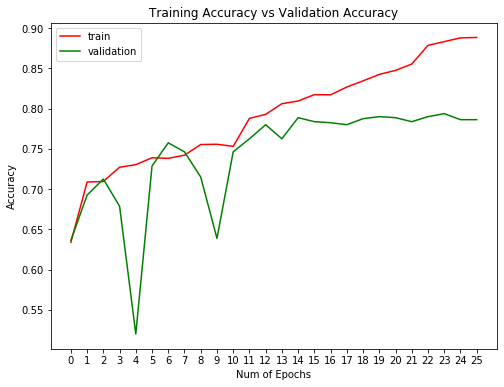

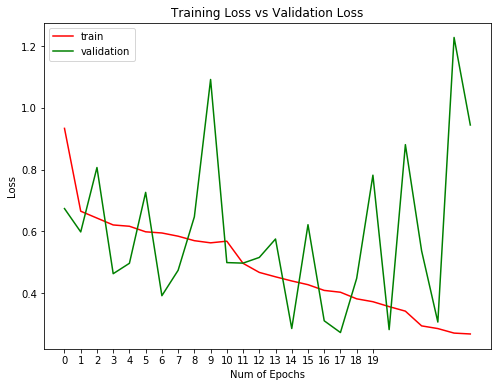

<Figure size 576x432 with 0 Axes>

In [20]:
plt.figure(0)
plt.plot(model_history.history['acc'],'r')
plt.plot(model_history.history['val_acc'],'g')
plt.xticks(np.arange(0, 26, 1.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])

plt.figure(1)
plt.plot(model_history.history['loss'],'r')
plt.plot(model_history.history['val_loss'],'g')
plt.xticks(np.arange(0, 20, 1.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])


plt.show()

In [85]:
prediction = model.predict(x_test)

In [86]:
prediction[0]

array([1.8129771e-05, 1.8282820e-02, 9.8169911e-01], dtype=float32)

In [87]:
level_arr=[]
for i in prediction:
    level = np.argmax(i)
    if level == 0:
        level ='A'
    elif level ==1:
        level ='B'
    else:
        level ='C'
    level_arr.append(level)
test_upload['label']=level_arr

In [89]:
upload_path = './Doc/0614_Dense121.csv'
test_upload.to_csv(upload_path,index = False,encoding='utf_8_sig')

In [13]:
model.save_weights('Mongo_weight.h5')